# Modeling GPP based on (dimension-reduced) mid-resolution hyperspectral data using random forests and PLSR

In [1]:
library(tidyverse)
#library(gridExtra) # not needed?
#library(grid)
library(lubridate)
library(sf)
library(hdf5r) # for loading example spectra
library(viridis)
library(scales) # for percentile colorbar scaling
library(repr) # for adjusting inline plot size
library(patchwork) # for residual scatterplot + density layout
#library(docstring)

library(mlr3verse)
library(mlr3extralearners)
library(visNetwork)
#library(mlr3spatiotempcv)
library(paradox)
lgr::get_logger('mlr3')$set_threshold('warn')
library(iml)
library(ranger) # loaded separately for prediction function for iml
library(DALEX)
library(DALEXtra)
library(SHAPforxgboost)

getCurrentFileLocation <-  function()
{
  this_file <- commandArgs() %>% 
    tibble::enframe(name = NULL) %>%
    tidyr::separate(col=value, into=c("key", "value"), sep="=", fill='right') %>%
    dplyr::filter(key == "--file") %>%
    dplyr::pull(value)
  if (length(this_file)==0)
  {
    this_file <- rstudioapi::getSourceEditorContext()$path
  }
  return(dirname(this_file))
}
wdir0 <- getCurrentFileLocation()

source(file.path(wdir0, 'R/misc_functions.R'))
plotdir <- paste0(wdir0, 'out/plots')

mlr_learners$add('regr.pls', LearnerRegrPls)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Linking to GEOS 3.12.0, GDAL 3.7.0, PROJ 9.2.1; sf_use_s2() is TRUE


Attaching package: ‘hdf5r’


The following object is masked from ‘package:purrr’:

    flatten_df


Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Warning message:
“packa

# I. Model comparison: BENCHMARK performance
## (A) Create tasks: all ecosystems & without CRO+GRA variants!

22 variants are compared: For each transformation method, 4, 10 and 20 components variants are tested. The three unsupervised transformation methods AE, SiVM and PCA are also used as input for a linear model for comparison with the non-linear baseline model random forest which is denoted by the \_LM suffix. All dimension reduction methods (incl. the NIRvP index method) were also tested with a reduced database excluding agricultural ecosystem types (cropland, grassland) indicated by the \_extES suffix.

In [ ]:
ip <- c(wdir=wdir0, sensor='PRISMA',
        sr='vnir', mask='bg', rad='ref', resp='GPP_DT_VUT_50')
tasknames <- c('AE04', 'AE04_extES', 'AE10', 'AE20',
               'SiVM04', 'SiVM04_extES', 'SiVM10', 'SiVM20',
               'PCA04', 'PCA04_extES', 'PCA10', 'PCA20',
               'PLS04', 'PLS04_extES', 'PLS10', 'PLS20',
               'NIRvP', 'NIRvP_extES')
combi <- rep(list(ip), length(tasknames)) # 4/10/20 LC variants of 4 DR methods: AE, SiVM, PCA, PLSR + 1 index method (NIRvP)

for (i in 1:length(combi)) {
  combi[[i]]['dimred'] <- ifelse(substr(tasknames[i], 1, 3) %in% c('PLS', 'NIR'), 'none', gsub('_.*', '', tasknames[i]))
}

flx_gdfs <- vector(mode='list', length=length(combi))
flx_ncols_spec <- vector(mode='integer', length=length(combi))
for (i in 1:length(combi)) {
  if (grepl('extES', tasknames[i], fixed = TRUE)) {
    args <- c(combi[[i]], list(exclude_es=c('CRO', 'GRA'), return_df=T))
  } else {
    args <- c(combi[[i]], list(exclude_es='none', return_df=T))
  }
  print(sprintf('Loading task %s', tasknames[i]))
  loaded <- do.call(load_flx_gdf, args)
  flx_gdfs[[i]] <- loaded$hsi_df
  flx_ncols_spec[i] <- loaded$nbands
  ntask <- TaskRegr$new(tasknames[i], flx_gdfs[[i]], target=args$resp)
  # stratify resampling so that ecosystem classes are evenly distributed among folds
  ntask$col_roles$stratum = 'ecosystem'
  mlr_tasks$add(tasknames[i], ntask)
}
names(flx_gdfs) = tasknames
tasks = lapply(tasknames, tsk)

# taskpaths is used for saving plots
taskpaths <- file.path(plotdir, tasknames)
lapply(taskpaths, function(x) if(!dir.exists(x)) dir.create(x, recursive=T))

## (B) Build pipelines

mlr3 docs regarding auto_tuner resampling:
>The mlr3::Resampling passed to the AutoTuner is meant to be the inner resampling, operating on the training set of an arbitrary outer resampling. For this reason, the inner resampling should be not instantiated.

All models use dummy variables (one-hot encoded) for ecosystem type categories. The dependent variable is square-root transformed to achieve a more uniform distribution.

In [3]:
graphs <- vector(mode='list', length=length(combi))
names(graphs) <- tasknames

for (i in 1:length(combi)) {
  cov0 <- po('select', id='covars', selector=selector_name(c('SPEI_365', 'PPI')))
  cov0 %>>%
    mlr_pipeops$get('scale', id='scale2', param_val=list(scale=TRUE, center=TRUE)) -> covars
  eco <- po('select', id='dummies', selector=selector_grep('^es.'))
  
  if (substr(tasknames[i], 1, 3) == 'PLS') {
    spectral <- po('select', id = 'bands', selector=selector_name(sprintf('b%03d', seq(1:flx_ncols_spec[i]))))
  } else if (substr(tasknames[i], 1, 3) == 'NIR') {
    spectral <- po('select', id = 'nirvp', selector=selector_name('NIRvP'))
  } else {
    spectral <- po('select', id = 'comps', selector=selector_name(sprintf('comp%02d', seq(1:flx_ncols_spec[i]))))
  }
  
  piper <- gunion(list(spectral, covars, eco)) %>>%
    mlr_pipeops$get('featureunion')
  piper$keep_results = TRUE # result of union must be kept for evaluation of tuned models
  
  if (substr(tasknames[i], 1, 3) == 'PLS') {
    ncomp=as.integer(substr(tasknames[i], 4, 5))
    graph <- piper %>>%
      mlr3pipelines::pipeline_targettrafo(mlr_pipeops$get(
        'learner', learner=lrn('regr.pls', ncomp=ncomp, scale=F, center=F)))
  } else {
    graph <- piper %>>%
      mlr3pipelines::pipeline_targettrafo(mlr_pipeops$get(
        'learner', learner=lrn('regr.ranger')))
  }
  graph$param_set$values$targetmutate.trafo = function(x) sqrt(x)
  graph$param_set$values$targetmutate.inverter = function(x) list(response = x$response**2)
  graphs[[i]] <- GraphLearner$new(graph)
}

Outer resampling for in nested resampling uses repeated cross-validation (CV) while inner resampling uses simple 6-fold CV. 3 main hyperparameters of the random forest (RF) are tuned using random search with 100 iterations. The PLS models are used as is in benchmarking.

In [4]:
outer_rsmp <- rsmp('repeated_cv', folds=5, repeats=4)
resamp <- rsmp('cv', folds=6)
measure <- msr('regr.rmse')

ps_rf <-  ps(
  regr.ranger.min.node.size = p_int(lower=3, upper=15),
  regr.ranger.mtry.ratio = p_dbl(lower=0.2, upper=1),
  regr.ranger.num.trees = p_int(lower=500, upper=1000)
)

models <- vector(mode='list', length=length(combi))
for (i in 1:length(combi)) {
  if (substr(tasknames[i], 1, 3) == 'PLS') {
    models[[i]] <- graphs[[i]]
  } else {
    models[[i]] <- auto_tuner(tuner=tnr('random_search'),
                              learner=graphs[[i]],
                              resampling=resamp,
                              measure=measure,
                              search_space=ps_rf,
                              term_evals=100)
  }
}

## (C) Perform benchmark

As the table for benchmark design is created manually, resampling also needs to be instantiated manually (normally done by `benchmark_grid`). The `future` package allows for parallel processing. The outer resampling loop is parallelized while inner resampling is performed sequentially.

In [5]:
design <- data.table::data.table(
  task=tasks, learner=models, resampling=list(outer_rsmp))

set.seed(10005)
design$resampling = Map(
  function(task, resampling) resampling$clone()$instantiate(task),
  task=design$task, resampling=design$resampling
)
# check variable distributions in fold like this:
#design$task[[1]]$data(rows=design$resampling[[1]]$test_set(1), cols='ecosystem')[[1]]

future::plan(list('multisession', 'sequential'))
bmr_strat <- benchmark(design, store_models=F)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [4]:
#bma_strat <- bmr_strat$aggregate(measure)[, c(1,3,7)]
bmr_strat$aggregate(list(msr('regr.rmse'), msr('regr.rsq'), msr('regr.bias')))[, c('task_id', 'regr.rmse', 'regr.rsq', 'regr.bias')]

task_id      regr.rmse regr.rsq  regr.bias 
1  AE04         6.363822  0.5174238  1.1121826
2  AE04_extES   5.763446  0.4852704  0.7779576
3  AE10         6.337884  0.5226051  1.1020415
4  AE20         6.884813  0.4349236  1.0643306
5  SiVM04       6.387585  0.5101732  0.8314963
6  SiVM04_extES 6.084230  0.4134477  0.7491180
7  SiVM10       6.003243  0.5694669  0.8858344
8  SiVM20       6.390720  0.5132309  1.1090720
9  PCA04        6.296167  0.5223087  1.0369098
10 PCA04_extES  6.059558  0.4435645  0.8255279
11 PCA10        6.391709  0.5032823  1.3491581
12 PCA20        6.569020  0.4848308  1.2729797
13 PLS04        6.491213  0.4914730  0.7245495
14 PLS04_extES  6.001435  0.4442224  0.5554482
15 PLS10        6.223355  0.5110626  0.5064603
16 PLS20        7.289869  0.3387593 -0.1185838
17 NIRvP        6.599902  0.4922727  1.1255853
18 NIRvP_extES  6.121776  0.4166422  0.9800512

# II. Benchmark diagnostics & model evaluation
For plotting and diagnostics the models have to be trained on the full dataset to obtain a set of optimized hyperparameters for creating model explanations with DALEX.

In [9]:
future::plan('multisession')
for (i in 1:length(combi)) {
  set.seed(10005)
  models[[i]]$train(tasks[[i]])
}

INFO  [18:38:20.145] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerRandomSearch>' and '<TerminatorEvals> [n_evals=100, k=0]'
INFO  [18:38:20.200] [bbotk] Evaluating 1 configuration(s)
INFO  [18:38:24.275] [bbotk] Result of batch 1:
INFO  [18:38:24.279] [bbotk]  regr.ranger.min.node.size regr.ranger.mtry.ratio regr.ranger.num.trees
INFO  [18:38:24.279] [bbotk]                          7              0.3775283                   515
INFO  [18:38:24.279] [bbotk]  regr.rmse warnings errors runtime_learners
INFO  [18:38:24.279] [bbotk]   6.432711        0      0            2.254
INFO  [18:38:24.279] [bbotk]                                 uhash
INFO  [18:38:24.279] [bbotk]  35cd9047-4045-43dd-a775-61757fc287b9
INFO  [18:38:24.284] [bbotk] Evaluating 1 configuration(s)
INFO  [18:38:25.744] [bbotk] Result of batch 2:
INFO  [18:38:25.748] [bbotk]  regr.ranger.min.node.size regr.ranger.mtry.ratio regr.ranger.num.trees
INFO  [18:38:25.748] [bbotk]                         10         

## (A) Plot feature contributions & values
In a first step, the optimized model objects for DALEX are created using output from the previous cell. These preparation functions have to treat PLS and RF models differently.

In [11]:
dalex_dfs <- lapply(1:length(combi), function(x){
  if ('regr.pls' %in% names(models[[x]]$state$model)) {
    as.data.table(models[[x]]$graph_model$pipeops$featureunion$.result$output$data())
  } else {
    as.data.table(models[[x]]$learner$graph$pipeops$featureunion$.result$output$data())
  }
})

dalex_x <- vector(mode='list', length=length(combi))
dalex_y <- vector(mode='list', length=length(combi))
dalex_models <- vector(mode='list', length=length(combi))
dalex_tasks <- vector(mode='list', length=length(combi))
for (i in 1:length(combi)) { # create data & models
  # import preprocessed data from pipeline for iml/DALEX model building
  dalex_x[[i]] <- dalex_dfs[[i]][ ,.SD, .SDcols = !combi[[i]]['resp']]
  dalex_y[[i]] <- dalex_dfs[[i]][ ,.SD, .SDcols = combi[[i]]['resp']][[1]]
  if ('regr.pls' %in% names(models[[i]]$state$model)) {
    lrnr <- lrn('regr.pls', scale=F, center=F,
                ncomp=as.integer(substr(tasknames[i], 4, 5)))
  } else {
    lrnr <- lrn('regr.ranger',
                min.node.size = models[[i]]$tuning_result$regr.ranger.min.node.size,
                mtry.ratio = models[[i]]$tuning_result$regr.ranger.mtry.ratio,
                num.trees = models[[i]]$tuning_result$regr.ranger.num.trees)
  }
  dalex_models[[i]] <- lrnr
  dalex_tasks[[i]] <- TaskRegr$new(sprintf('task%02d_%s', i, tasknames[i]),
                                   dalex_dfs[[i]], target = combi[[i]]['resp'])
}

First, DALEX explainer wrappers are created for all models. For all RF models, SHAP values are also calculated and a SHAP summary plot is created. PLS models are excluded from SHAP calculation as this cannot be done straightforward using mlr3 objects. Since PLS entries are skipped, the corresponding lists (`shaps_long`, `ps_shap`) are eventually trimmed.

In [12]:
dalex_exps <- vector(mode='list', length=length(combi))
shaps_long <- vector(mode='list', length=length(combi))
ps_shap <- vector(mode='list', length=length(combi))

# DALEX explainers are created for all models, in SHAP value calculation PLS is excluded
future::plan(list('multisession', 'sequential'))
for (i in 1:length(combi)) {
  dalex_models[[i]]$train(dalex_tasks[[i]])
  dalex_exps[[i]] <- explain_mlr3(dalex_models[[i]], data = dalex_x[[i]], y = dalex_y[[i]],
                                  label = sprintf('exp%02d_%s', i, tasknames[i]), colorize = FALSE)
  
  if ('regr.pls' %in% names(models[[i]]$state$model)) {
    message('PLS skipped')
  } else {
    shap_values <- data.frame(matrix(0, nrow(dalex_dfs[[i]]), ncol(dalex_x[[i]])))
    
    for (j in 1:nrow(dalex_dfs[[i]])) {
      shap_single <- predict_parts(dalex_exps[[i]], type = 'shap',
                                   new_observation = as.data.frame(dalex_dfs[[i]][j, ]),)
      shap_wide <- as.data.frame(shap_single) %>%
        pivot_wider(id_cols = 'B', names_from = 'variable_name', values_from = 'contribution')
      shap_wide_aggr <- shap_wide[2:ncol(shap_wide)] %>% colMeans()
      shap_values[j, ] <- shap_wide_aggr
    }
    names(shap_values) <- names(shap_wide_aggr)
    shaps_long[[i]] <- shap.prep(shap_contrib = shap_values, X_train = dalex_x[[i]])
    ps_shap[[i]] <- shap.plot.summary(shaps_long[[i]]) + theme(text = element_text(size=24))
  }
}
names(shaps_long) <- tasknames
shaps_long <- shaps_long[-which(sapply(shaps_long, is.null))]
ps_shap <- ps_shap[-which(sapply(ps_shap, is.null))]
shapnames <- names(shaps_long)

Preparation of a new explainer is initiated
  -> model label       :  exp01_AE04 
  -> data              :  144  rows  13  cols 
  -> target variable   :  144  values 
  -> predict function  :  yhat.LearnerRegr  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package mlr3 , ver. 0.16.1 , task regression (  default  ) 
  -> predicted values  :  numerical, min =  1.239625 , mean =  14.75531 , max =  37.81603  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -8.939755 , mean =  0.01648122 , max =  7.634018  
  A new explainer has been created!  
Preparation of a new explainer is initiated
  -> model label       :  exp02_AE04_extES 
  -> data              :  101  rows  11  cols 
  -> target variable   :  101  values 
  -> predict function  :  yhat.LearnerRegr  will be used (  default  )
  -> predicted values  :  No value for predict fun

PLS skipped



Preparation of a new explainer is initiated
  -> model label       :  exp14_PLS04_extES 
  -> data              :  101  rows  73  cols 
  -> target variable   :  101  values 
  -> predict function  :  yhat.LearnerRegr  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package mlr3 , ver. 0.16.1 , task regression (  default  ) 
  -> predicted values  :  numerical, min =  -3.857559 , mean =  13.97617 , max =  31.98117  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -11.76013 , mean =  -0.07601325 , max =  18.10701  
  A new explainer has been created!  


PLS skipped



Preparation of a new explainer is initiated
  -> model label       :  exp15_PLS10 
  -> data              :  144  rows  75  cols 
  -> target variable   :  144  values 
  -> predict function  :  yhat.LearnerRegr  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package mlr3 , ver. 0.16.1 , task regression (  default  ) 
  -> predicted values  :  numerical, min =  -4.102142 , mean =  14.682 , max =  37.71408  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -20.55797 , mean =  0.08978376 , max =  18.12128  
  A new explainer has been created!  


PLS skipped



Preparation of a new explainer is initiated
  -> model label       :  exp16_PLS20 
  -> data              :  144  rows  75  cols 
  -> target variable   :  144  values 
  -> predict function  :  yhat.LearnerRegr  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package mlr3 , ver. 0.16.1 , task regression (  default  ) 
  -> predicted values  :  numerical, min =  -2.10735 , mean =  14.77166 , max =  40.08016  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -15.58544 , mean =  0.0001314343 , max =  16.10953  
  A new explainer has been created!  


PLS skipped



Preparation of a new explainer is initiated
  -> model label       :  exp17_NIRvP 
  -> data              :  144  rows  10  cols 
  -> target variable   :  144  values 
  -> predict function  :  yhat.LearnerRegr  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package mlr3 , ver. 0.16.1 , task regression (  default  ) 
  -> predicted values  :  numerical, min =  2.532815 , mean =  14.76703 , max =  34.77787  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -10.94899 , mean =  0.004752478 , max =  11.27095  
  A new explainer has been created!  
Preparation of a new explainer is initiated
  -> model label       :  exp18_NIRvP_extES 
  -> data              :  101  rows  8  cols 
  -> target variable   :  101  values 
  -> predict function  :  yhat.LearnerRegr  will be used (  default  )
  -> predicted values  :  No value for predict f

### SHAP summary plots

[1] "SiVM10"

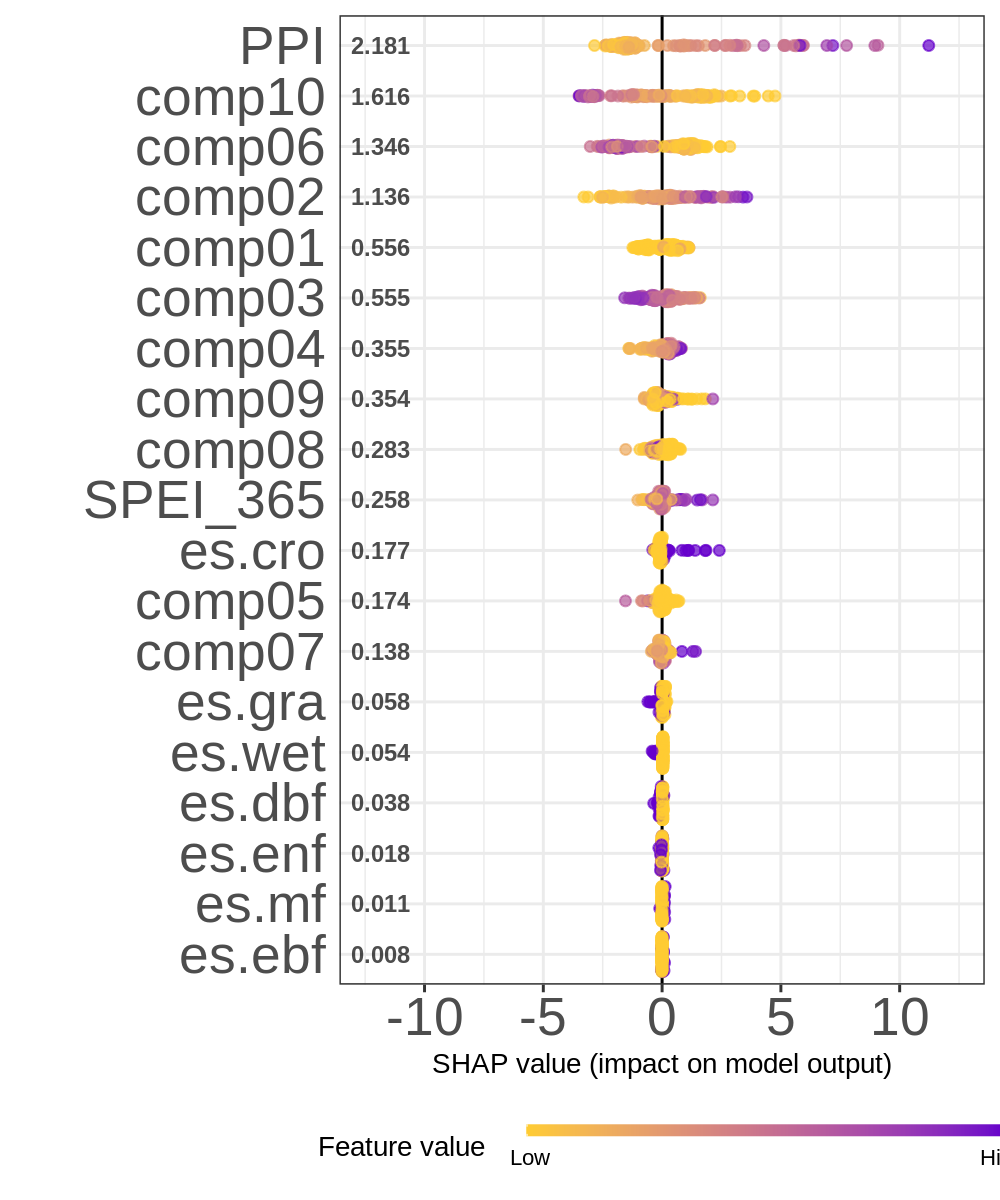

In [3]:
shapnames[7]
fig(5, 6, 40, 200)
ps_shap[[7]]

In [4]:
taskpaths_shap <- taskpaths[taskpaths %>% substr(58,60) != 'PLS']

In [ ]:
for (i in 1:length(shaps_long)) {
  nvar <- shaps_long[[i]]$variable %>% levels %>% length
  h <- ifelse(nvar > 20, 36,
              ifelse(nvar > 15, 30,
                     ifelse(nvar > 10, 24, 18)))
  ggsave(file.path(taskpaths_shap[i], sprintf('shap_summary_%s.png', names(shaps_long)[i])), ps_shap[[i]], device='png',
         scale=.7, width=20, height=h, units='cm', dpi=300)
}

Pretty summary plot for a single model

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


[1] "AE04"

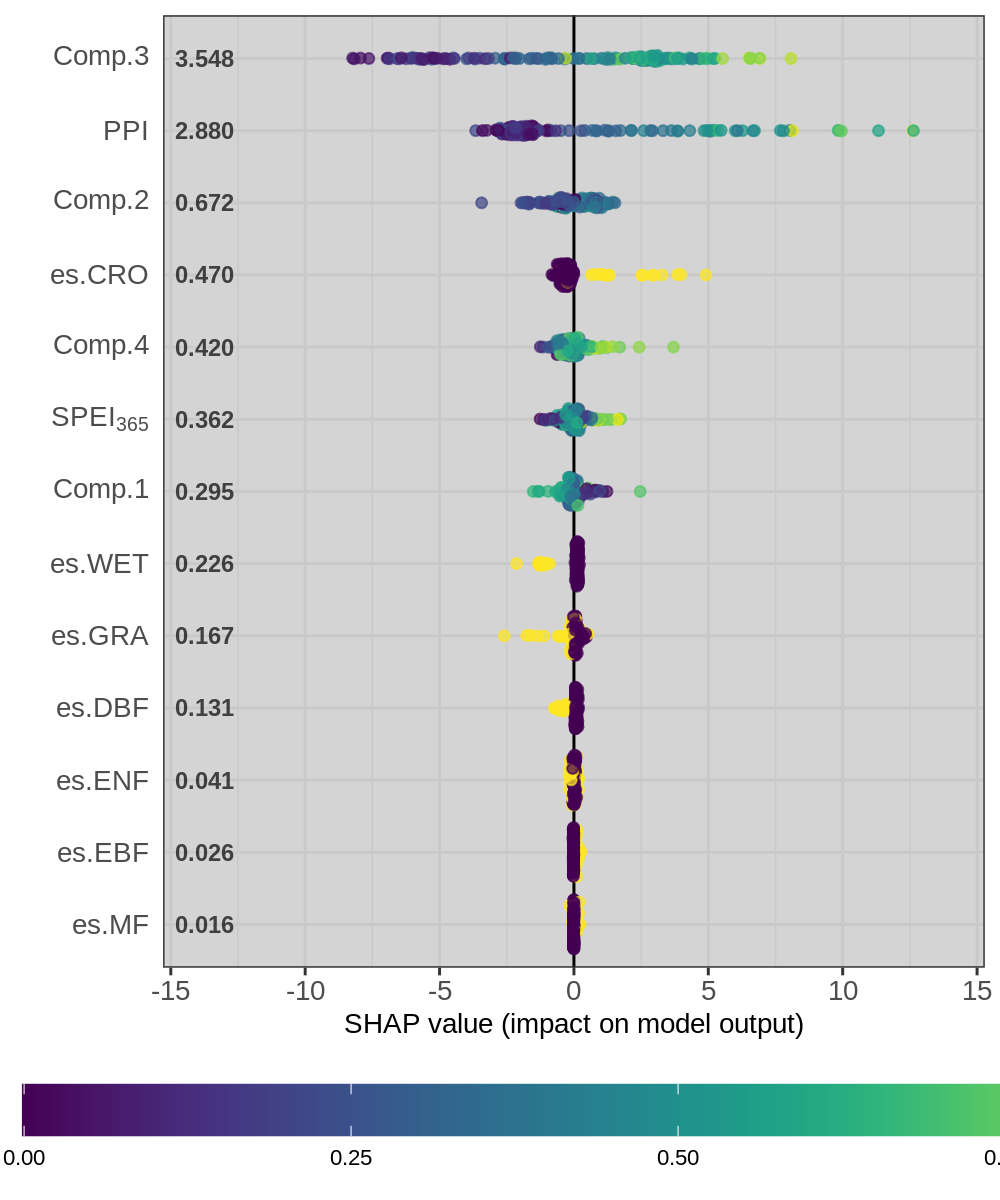

In [5]:
ix <- 1
p_shap <- shap.plot.summary(shaps_long[[ix]]) +
  #scale_x_discrete(limits=rev, labels=rev(levels(shaps_long[[ix]]$variable))) +
  scale_x_discrete(limits=rev, labels=c('es.MF', 'es.EBF', 'es.ENF', 'es.DBF', 'es.GRA', 'es.WET', 'Comp.1',
                                        expression(SPEI[365]), 'Comp.4', 'es.CRO', 'Comp.2', 'PPI', 'Comp.3')) +
  scale_colour_viridis(guide = guide_colourbar()) +
  theme(axis.text = element_text(size=10),
        panel.background = element_rect(fill='grey83'),
        panel.grid.major=element_line(colour='grey79'),
        panel.grid.minor=element_line(colour='grey79'),
        legend.key.width = unit(dev.size()[1] / 2, 'cm'),
        legend.key.height = unit(dev.size()[1] / 10, 'cm'))
shapnames[ix]

fig(5, 6, 40, 200)
p_shap
#ggsave(file.path(taskpaths_shap[ix], sprintf('shap_summary_%s_pretty.png', names(shaps_long)[ix])), p_shap, device='png',
#       scale=.7, width=18, height=16, units='cm', dpi=300)

Grouped SHAP summary plot of three 4-comp models. Methods: autoencoder (AE), simplex volume maximisation (SiVM), principal components (PCA). Model type is added to the long data.tables of SHAP values as a new column. This grouping column is used for facetting in the call to the custom SHAP summary plot function imported from "add_funs.R".

In [6]:
ix_4c <- which((grepl('04', shapnames, fixed=T) | grepl('NIR', shapnames, fixed=T)) & !grepl('extES', shapnames, fixed=T) & !grepl('PLS', shapnames, fixed=T))
shaps_long_4c <- vector(mode='list', length=length(ix_4c))

for (i in seq_along(ix_4c)) {
  shaps_long_4c_df <- shaps_long[[ix_4c[i]]]
  shaps_long_4c_df$dr_mod <- shapnames[ix_4c[i]]
  shaps_long_4c[[i]] <- shaps_long_4c_df
}
names(shaps_long_4c) <- shapnames[ix_4c]
shap_long_c <- bind_rows(shaps_long_4c)
shap_long_c$dr_mod <- factor(shap_long_c$dr_mod, levels=c('AE04','SiVM04','PCA04','NIRvP'))

[1] "Orig labels:  comp03 PPI comp02 es.cro comp04 SPEI_365 comp01 es.wet es.gra es.dbf es.enf es.ebf es.mf NIRvP"
[1] "Alph. rank:  3 13 2 5 4 14 1 11 9 6 8 7 10 12"
[1] "Cor. labels:  Comp.3 PPI Comp.2 es.CRO Comp.4 SPEI[365] Comp.1 es.WET es.GRA es.DBF es.ENF es.EBF es.MF NIRvP"


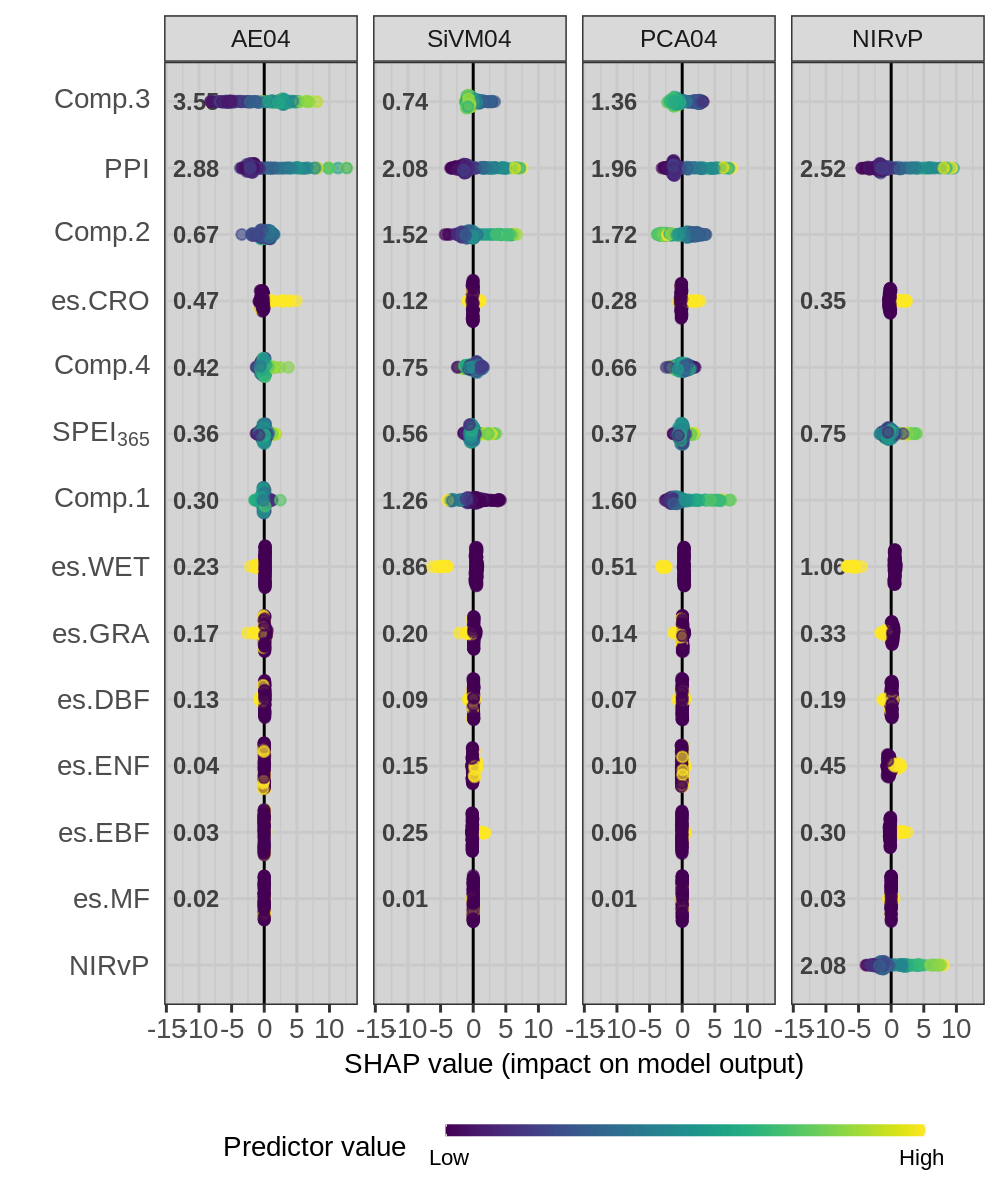

In [9]:
ndict <- c('1'='Comp.1', '2'='Comp.2', '3'='Comp.3', '4'='Comp.4', '5'='es.CRO', '6'='es.DBF', '7'='es.EBF',
           '8'='es.ENF', '9'='es.GRA', '10'='es.MF', '11'='es.WET', '12'='NIRvP', '13'='PPI', '14'=expression(SPEI[365]))
# pass the formatted variable names in alphabetical order. Variable name vector in data long and namedict must be of equal length
p_shap_4c <- shap.sum.facet(data_long=shap_long_c, namedict=ndict, x_bound=c(-14,13))
p_shap_4c
#ggsave(file.path(plotdir, 'shap_summary_4comp_grid.png'),
#       p_shap_4c, device='png', width=20, height=13, units='cm', dpi=300)

[1] "Orig labels:  comp03 PPI comp02 SPEI_365 comp01 es.enf comp04 es.mf es.wet es.dbf es.ebf NIRvP"
[1] "Alph. rank:  3 11 2 12 1 7 4 8 9 5 6 10"
[1] "Cor. labels:  Comp.3 PPI Comp.2 SPEI[365] Comp.1 es.ENF Comp.4 es.MF es.WET es.DBF es.EBF NIRvP"


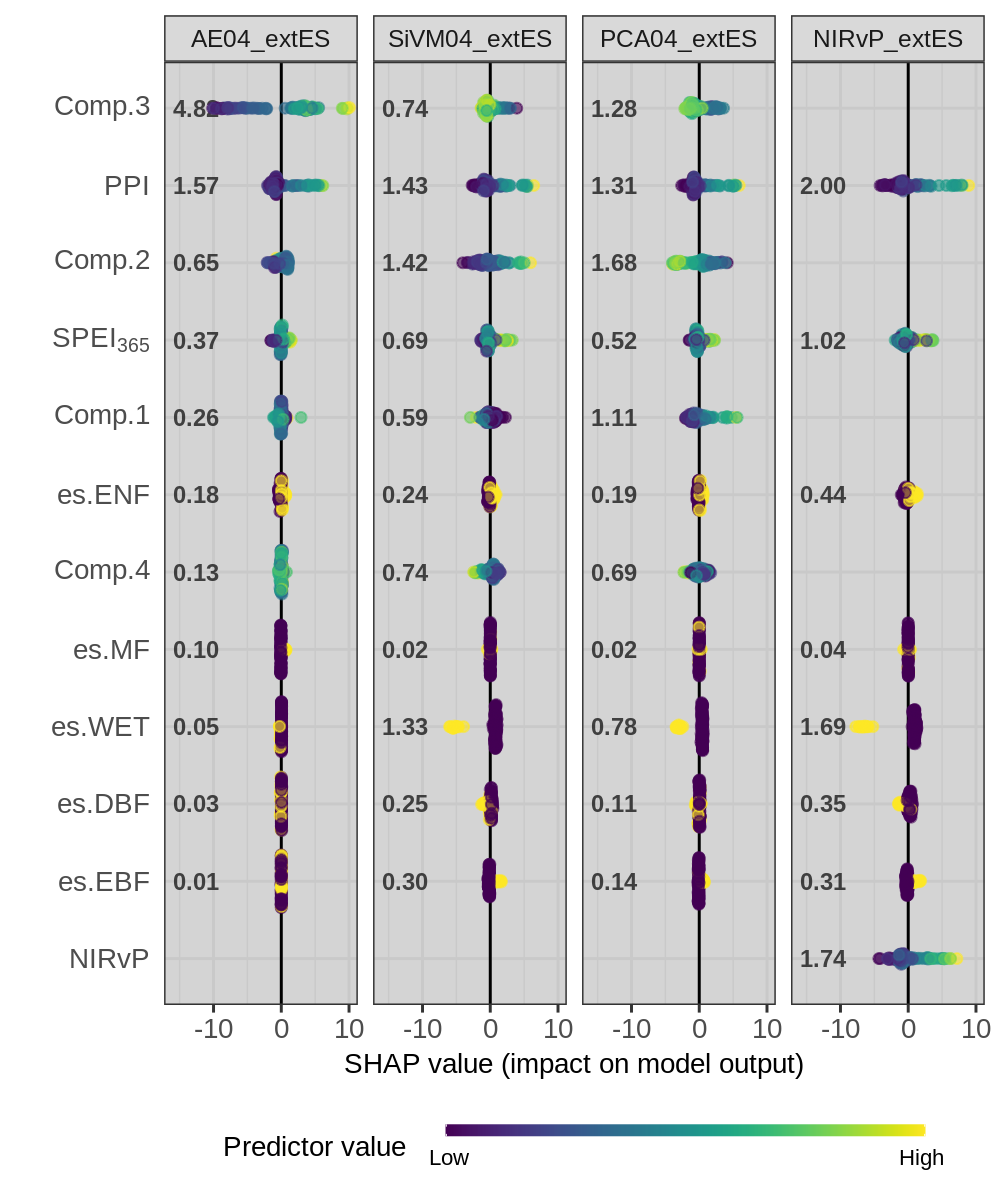

In [10]:
ix_4c_ee <- which(grepl('extES', shapnames, fixed=T))
shaps_long_4c_ee <- vector(mode='list', length=length(ix_4c_ee))

for (i in seq_along(ix_4c_ee)) {
  shaps_long_4c_df_ee <- shaps_long[[ix_4c_ee[i]]]
  shaps_long_4c_df_ee$dr_mod <- shapnames[ix_4c_ee[i]]
  shaps_long_4c_ee[[i]] <- shaps_long_4c_df_ee
}
names(shaps_long_4c_ee) <- shapnames[ix_4c_ee]
shap_long_c_ee <- bind_rows(shaps_long_4c_ee)
shap_long_c_ee$dr_mod <- factor(shap_long_c_ee$dr_mod, levels=c('AE04_extES','SiVM04_extES','PCA04_extES','NIRvP_extES'))

#levels(shap_long_c_ee$variable)
ndict <- c('1'='Comp.1', '2'='Comp.2', '3'='Comp.3', '4'='Comp.4', '5'='es.DBF', '6'='es.EBF',
           '7'='es.ENF', '8'='es.MF', '9'='es.WET', '10'='NIRvP', '11'='PPI', '12'=expression(SPEI[365]))
p_shap_4c_ee <- shap.sum.facet(shap_long_c_ee, namedict=ndict, x_bound=c(-16,10))
p_shap_4c_ee
#ggsave(file.path(plotdir, 'shap_summary_4comp_extES_grid.png'),
#       p_shap_4c_ee, device='png', width=20, height=11.5, units='cm', dpi=300)

[1] "Orig labels:  comp02 PPI comp05 comp06 comp03 comp09 comp07 comp08 es.cro comp10 comp01 comp04 SPEI_365 es.wet es.gra es.dbf es.enf es.mf es.ebf"
[1] "Alph. rank:  2 18 5 6 3 9 7 8 11 10 1 4 19 17 15 12 14 16 13"
[1] "Cor. labels:  Comp.2 PPI Comp.5 Comp.6 Comp.3 Comp.9 Comp.7 Comp.8 es.CRO Comp.10 Comp.1 Comp.4 SPEI[365] es.WET es.GRA es.DBF es.ENF es.MF es.EBF"


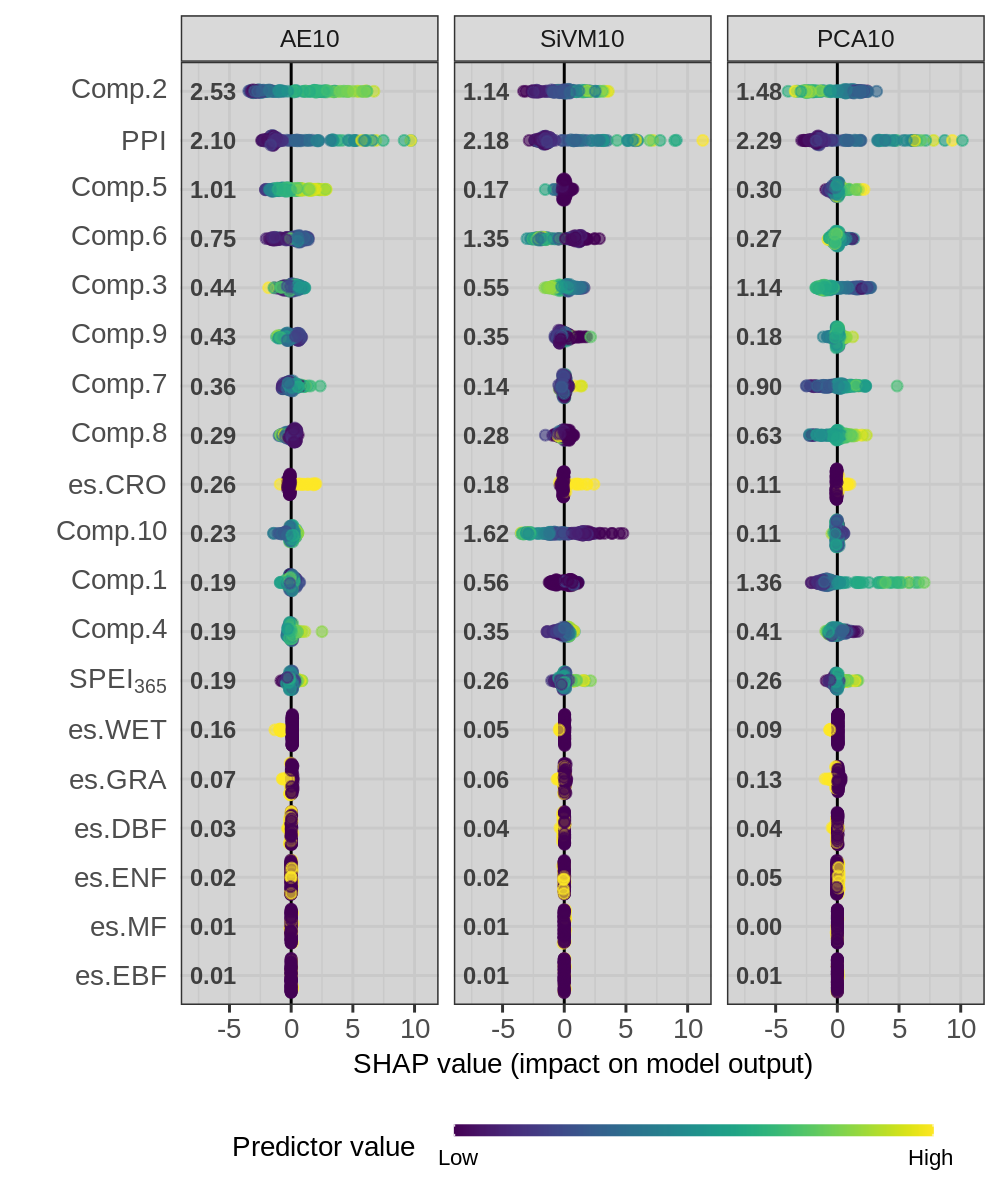

In [28]:
ix_10c <- which(grepl('10', shapnames, fixed=T) & !grepl('extES', shapnames, fixed=T) & !grepl('PLS', shapnames, fixed=T))
shaps_long_10c <- vector(mode='list', length=length(ix_10c))

for (i in seq_along(ix_10c)) {
  shaps_long_10c_df <- shaps_long[[ix_10c[i]]]
  shaps_long_10c_df$dr_mod <- shapnames[ix_10c[i]]
  shaps_long_10c[[i]] <- shaps_long_10c_df
}
names(shaps_long_10c) <- shapnames[ix_10c]
shap_long_10 <- bind_rows(shaps_long_10c)
shap_long_10$dr_mod <- factor(shap_long_10$dr_mod, levels=c('AE10','SiVM10','PCA10'))

ndict <- c('1'='Comp.1', '2'='Comp.2', '3'='Comp.3', '4'='Comp.4', '5'='Comp.5', '6'='Comp.6', '7'='Comp.7',
           '8'='Comp.8', '9'='Comp.9', '10'='Comp.10', '11'='es.CRO', '12'='es.DBF', '13'='es.EBF', '14'='es.ENF',
           '15'='es.GRA', '16'='es.MF', '17'='es.WET', '18'='PPI', '19'=expression(SPEI[365]))
# pass the formatted variable names in alphabetical order. Variable name vector in data long and namedict must be of equal length
p_shap_10c <- shap.sum.facet(data_long=shap_long_10, namedict=ndict, x_bound=c(-8,11))
p_shap_10c
#ggsave(plotdir, 'shap_summary_10comp_grid.png'),
#       p_shap_10c, device='png', width=17, height=14, units='cm', dpi=300)

### SHAP dependence plot
Displays variable value vs variable SHAP value for a single variable.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


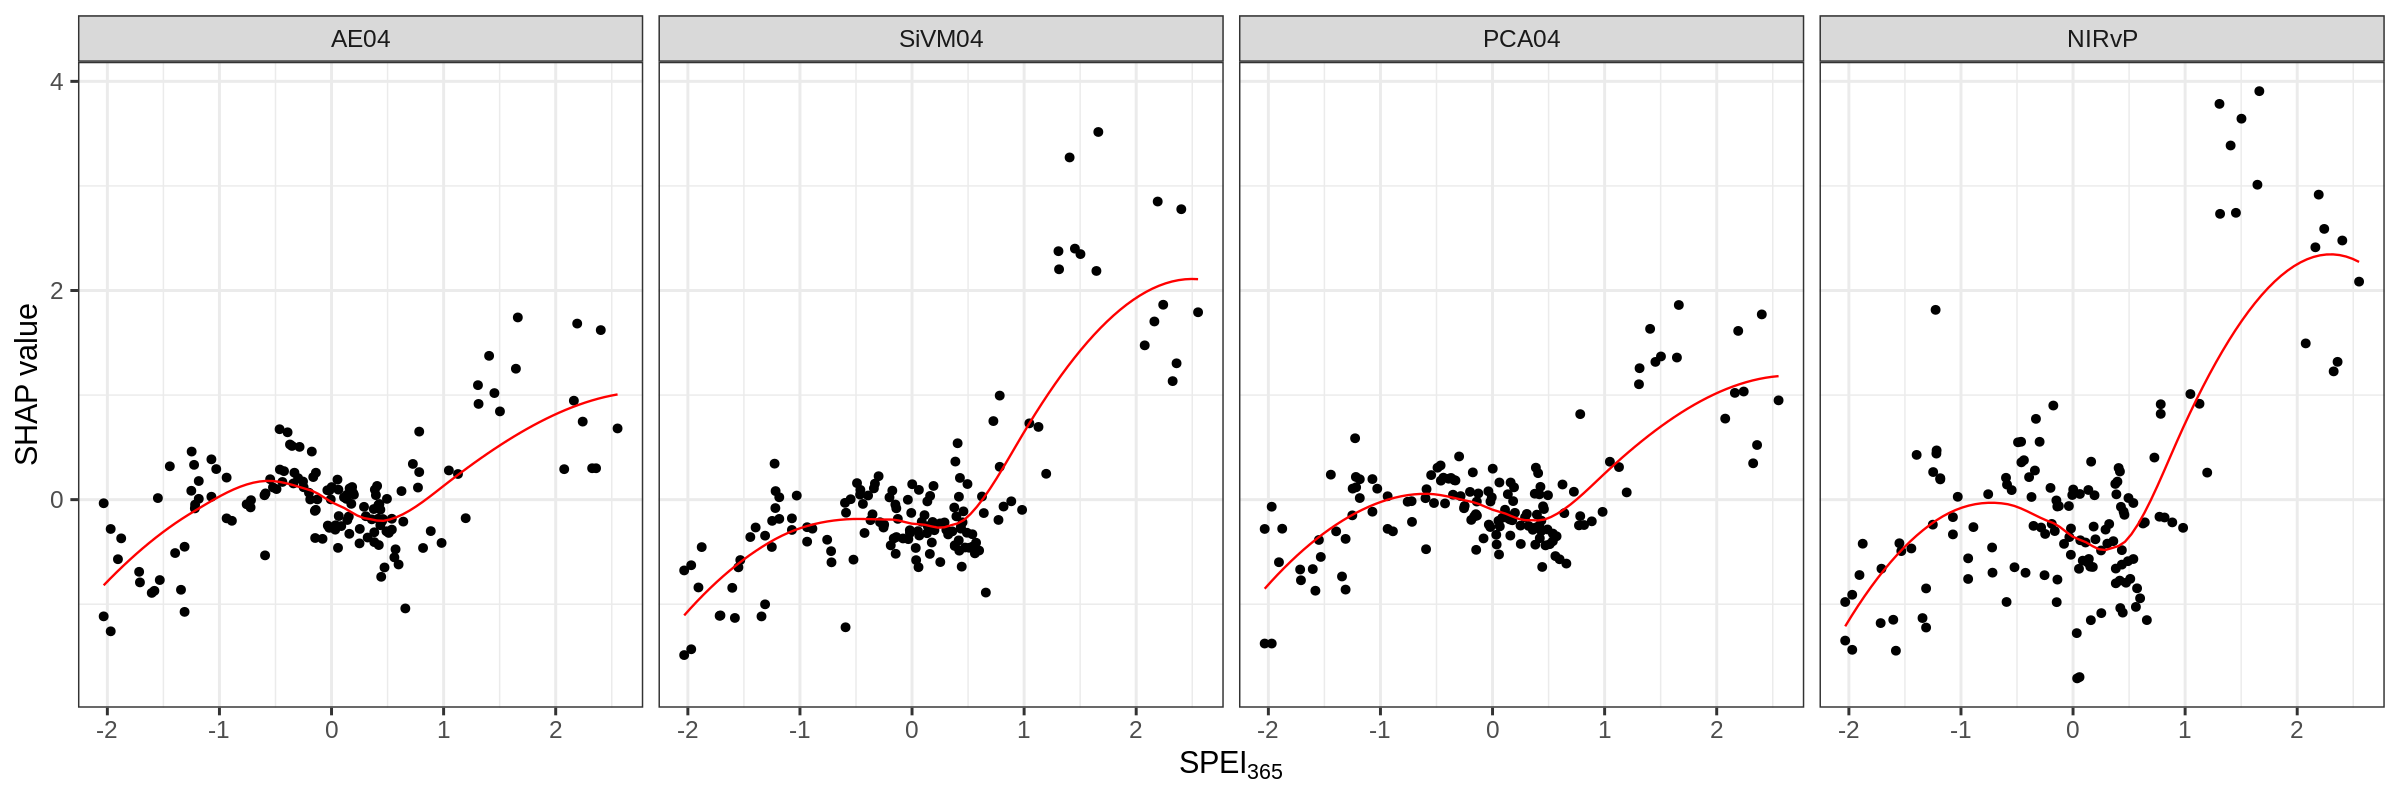

In [53]:
ix_4c <- which((grepl('04', shapnames, fixed=T) | grepl('NIR', shapnames, fixed=T)) & !grepl('extES', shapnames, fixed=T) & !grepl('PLS', shapnames, fixed=T))
# ix_4c means 1, 5, 9, 13 = AE04, SiVM04, PCA04, NIRvP
sls_spei <- vector(mode='list', length=length(ix_4c))
for (i in seq_along(ps_sdspei)) {
    sls_spei[[i]] <- shaps_long[[ix_4c[i]]]
    sls_spei[[i]]$dr_mod <- shapnames[ix_4c[i]]
}
names(sls_spei) <- shapnames[ix_4c]
sl_spei <- bind_rows(sls_spei)
sl_spei$dr_mod <- factor(sl_spei$dr_mod, levels=shapnames[ix_4c])
p_sdspei <- shap.dep.facet(data_long=sl_spei, x='SPEI_365') + ylab('SHAP value') + xlab(expression(SPEI[365]))

fig(12, 4, 40, 200)
p_sdspei
ggsave(file.path(plotdir, 'shap_dep_spei_4c.png'),
       p_sdspei, device='png', scale=2, width=13, height=4, units='cm', dpi=300)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


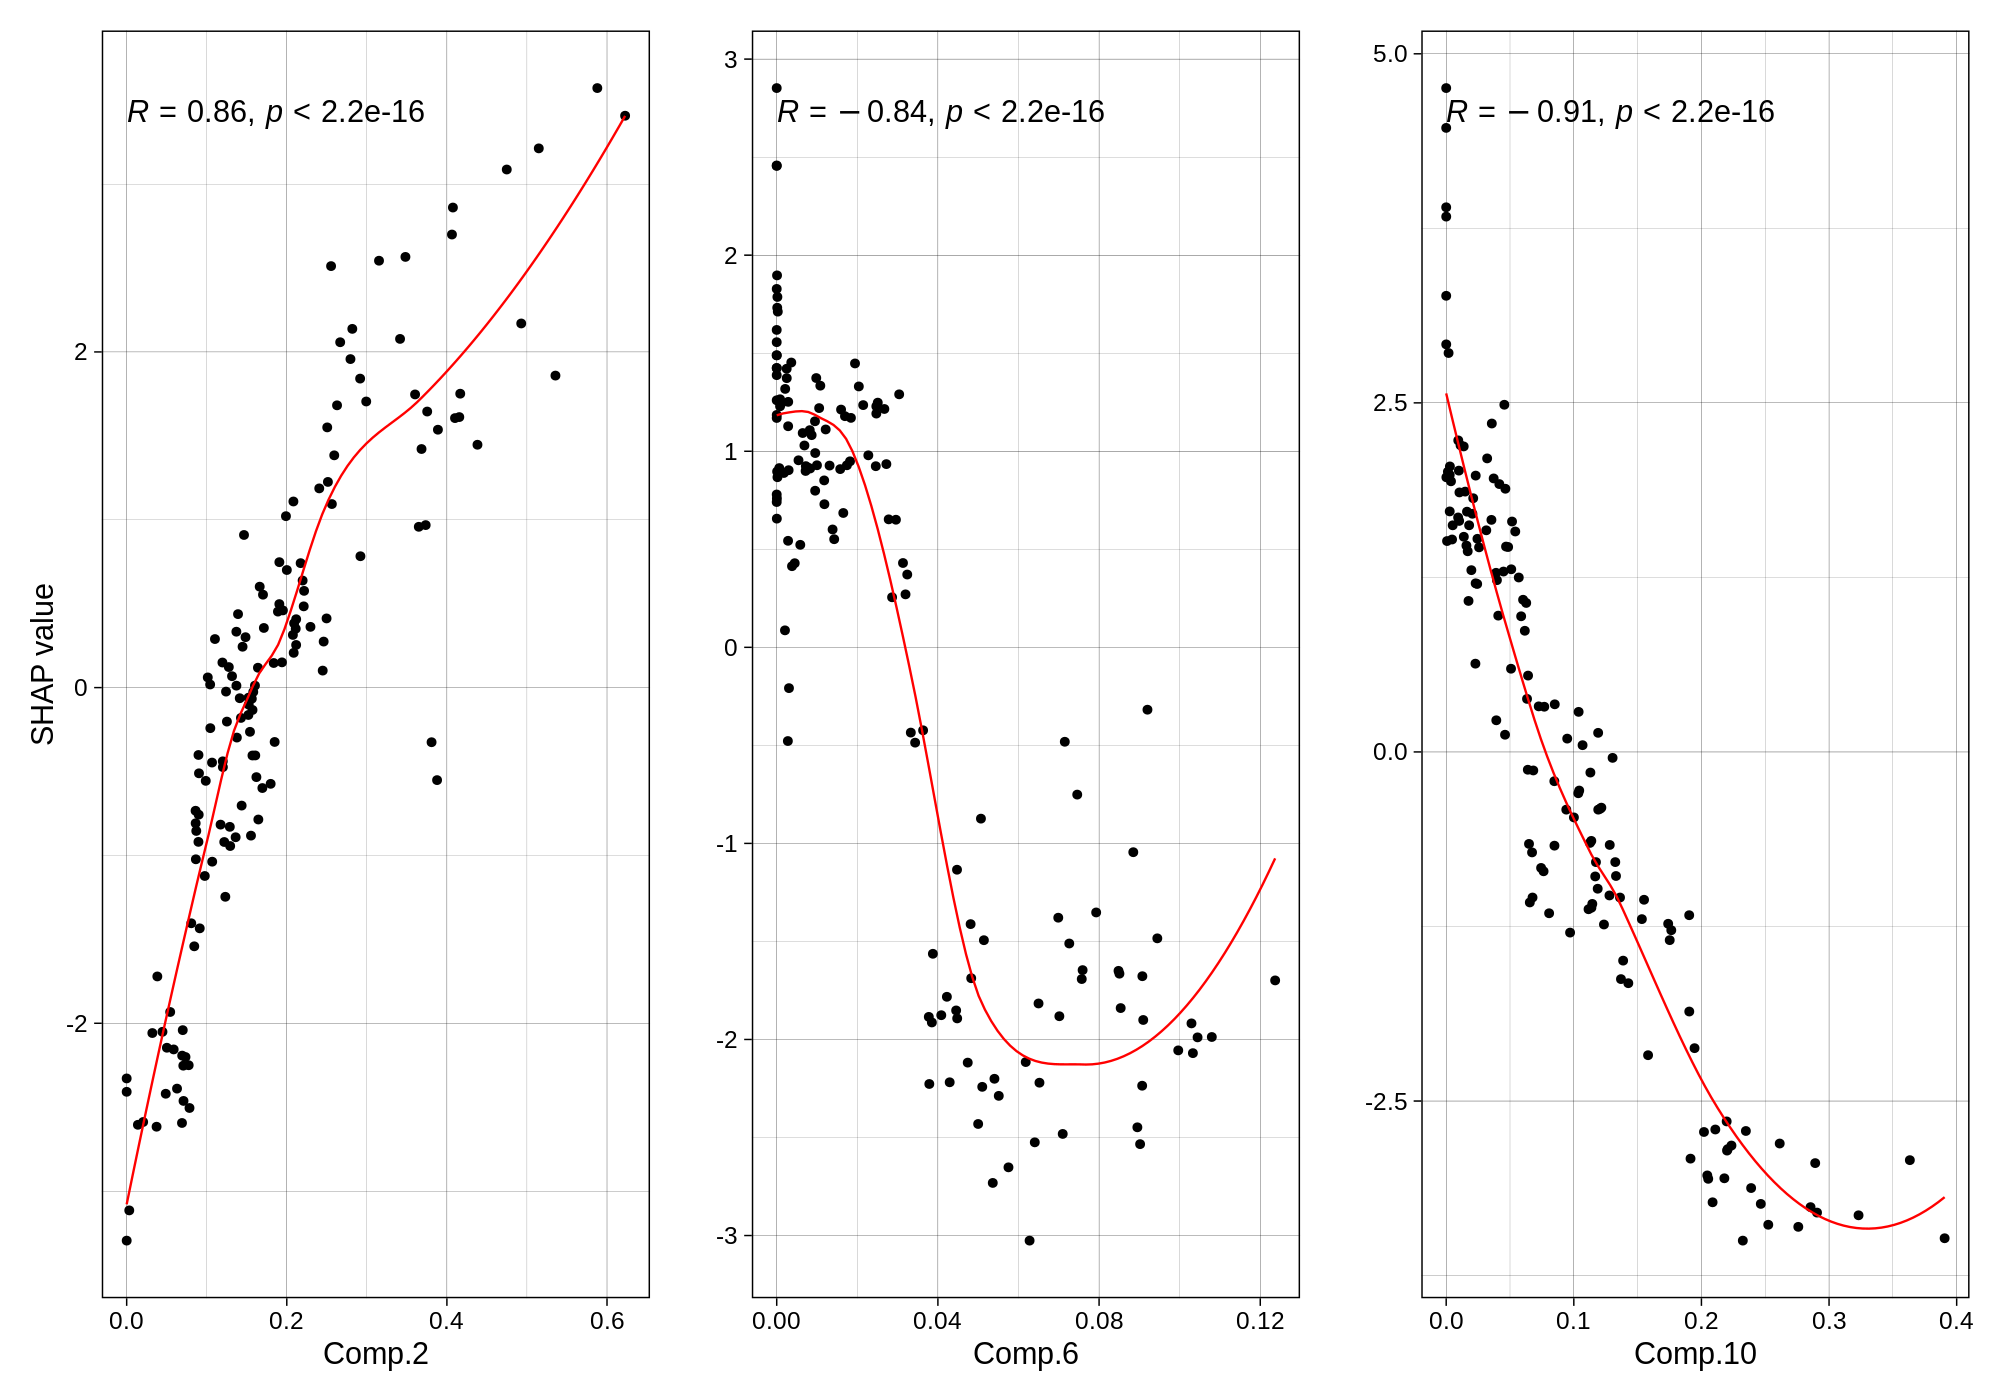

In [41]:
ps_sd <- vector(mode='list', length=3)
ix <- 7
vars <- c('comp02', 'comp06', 'comp10')
#lab <- expression(SPEI[365])
labs <- c('Comp.2', 'Comp.6', 'Comp.10')
for (i in seq_along(ps_sd)) {
    ps_sd[[i]] <- shap.plot.dependence(data_long=shaps_long[[ix]], x=vars[i], y=vars[i], add_stat_cor=T) +
    # interaction with other feature can be used for coloring points by using "color_feature" arg
    #scale_colour_viridis(guide=guide_colourbar(), name=lab) +
    #geom_smooth(method='loess', se=F, color='grey30', linewidth=.5) +
    {if(i==1) ylab('SHAP value') else ylab('')} +
    xlab(labs[i]) +
    theme_linedraw()
}

fig(10, 7, 40, 200)
p_sd <- patchwork::wrap_plots(ps_sd[[1]], ps_sd[[2]] , ps_sd[[3]] , widths = c(1,1,1), heights = c(.3,.3,.3), ncol=3, nrow=1)
p_sd
ggsave(file.path(plotdir, sprintf('shap_dep_impcomps_%s.png', names(shaps_long)[ix])),
       p_sd, device='png', scale=2, width=12, height=4, units='cm', dpi=300)

### Score boxplots for 8 4-comp variants

In [185]:
# Correlations of most important comps (mean absolute SHAP > 1) with obs. GPP
cors <- data.frame('AE.c2' = c(cor(models[[1]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,3)])[1,2],
                               cor(models[[2]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,3)])[1,2],
                               cor(models[[3]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,3)])[1,2]),
                   'AE.c3' = c(cor(models[[1]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,4)])[1,2],
                               cor(models[[2]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,4)])[1,2],
                               cor(models[[3]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,4)])[1,2]),
                   'AE.c5' = c(0, 0, cor(models[[3]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,6)])[1,2]),
                   'SiVM.c1' = c(cor(models[[5]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,2)])[1,2],
                                 cor(models[[6]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,2)])[1,2],
                                 cor(models[[7]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,2)])[1,2]),
                   'SiVM.c2' = c(cor(models[[5]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,3)])[1,2],
                                 cor(models[[6]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,3)])[1,2],
                                 cor(models[[7]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,3)])[1,2]),
                   'SiVM.c6' = c(0, 0, cor(models[[7]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,7)])[1,2]),
                   'SiVM.c10' = c(0, 0, cor(models[[7]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,11)])[1,2]),
                   'PCA.c1' = c(cor(models[[9]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,2)])[1,2],
                                cor(models[[10]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,2)])[1,2],
                                cor(models[[11]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,2)])[1,2]),
                   'PCA.c2' = c(cor(models[[9]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,3)])[1,2],
                                cor(models[[10]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,3)])[1,2],
                                cor(models[[11]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,3)])[1,2]),
                   'PCA.c3' = c(cor(models[[9]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,4)])[1,2],
                                cor(models[[10]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,4)])[1,2],
                                cor(models[[11]]$learner$graph_model$pipeops$comps$.result$output$data()[, c(1,4)])[1,2]),
                   'PLS.c1' = c(cor(data.frame(tasks[[13]]$data()$GPP_DT_VUT_50, models[[13]]$graph_model$state$regr.pls$model$scores[, 1]))[1,2],
                                cor(data.frame(tasks[[14]]$data()$GPP_DT_VUT_50, models[[14]]$graph_model$state$regr.pls$model$scores[, 1]))[1,2],
                                cor(data.frame(tasks[[15]]$data()$GPP_DT_VUT_50, models[[15]]$graph_model$state$regr.pls$model$scores[, 1]))[1,2]),
                   'PLS.c2' = c(cor(data.frame(tasks[[13]]$data()$GPP_DT_VUT_50, models[[13]]$graph_model$state$regr.pls$model$scores[, 2]))[1,2],
                                cor(data.frame(tasks[[14]]$data()$GPP_DT_VUT_50, models[[14]]$graph_model$state$regr.pls$model$scores[, 2]))[1,2],
                                cor(data.frame(tasks[[15]]$data()$GPP_DT_VUT_50, models[[15]]$graph_model$state$regr.pls$model$scores[, 2]))[1,2]),
                   'NIRvP' = c(cor(models[[17]]$learner$graph_model$pipeops$featureunion$.result$output$data()[, c(1,2)])[1,2],
                               cor(models[[18]]$learner$graph_model$pipeops$featureunion$.result$output$data()[, c(1,2)])[1,2], 0))
cors$models <- c('04', '04_extES', '10')
cors <- data.table::transpose(cors, make.names='models', keep.names='comp')
cors
#cor.test(unlist(models[[2]]$learner$graph_model$pipeops$comps$.result$output$data()[, 1]),
#         unlist(models[[2]]$learner$graph_model$pipeops$comps$.result$output$data()[, 4]))

comp     04          04_extES   10         
1  AE.c2     0.03614342 -0.1410854  0.60560749
2  AE.c3     0.62265840  0.7300317  0.35119417
3  AE.c5     0.00000000  0.0000000  0.53980045
4  SiVM.c1  -0.32208966 -0.2808650  0.02048064
5  SiVM.c2   0.52742502  0.5187153  0.58375034
6  SiVM.c6   0.00000000  0.0000000 -0.48255490
7  SiVM.c10  0.00000000  0.0000000 -0.55352870
8  PCA.c1    0.46693085  0.4436083  0.46693085
9  PCA.c2   -0.45078847 -0.5379186 -0.45078793
10 PCA.c3   -0.30833810 -0.2817525 -0.30833860
11 PLS.c1    0.55771742  0.5650443  0.55771742
12 PLS.c2   -0.25196593 -0.2604585 -0.25196593
13 NIRvP     0.59972236  0.5448499  0.00000000

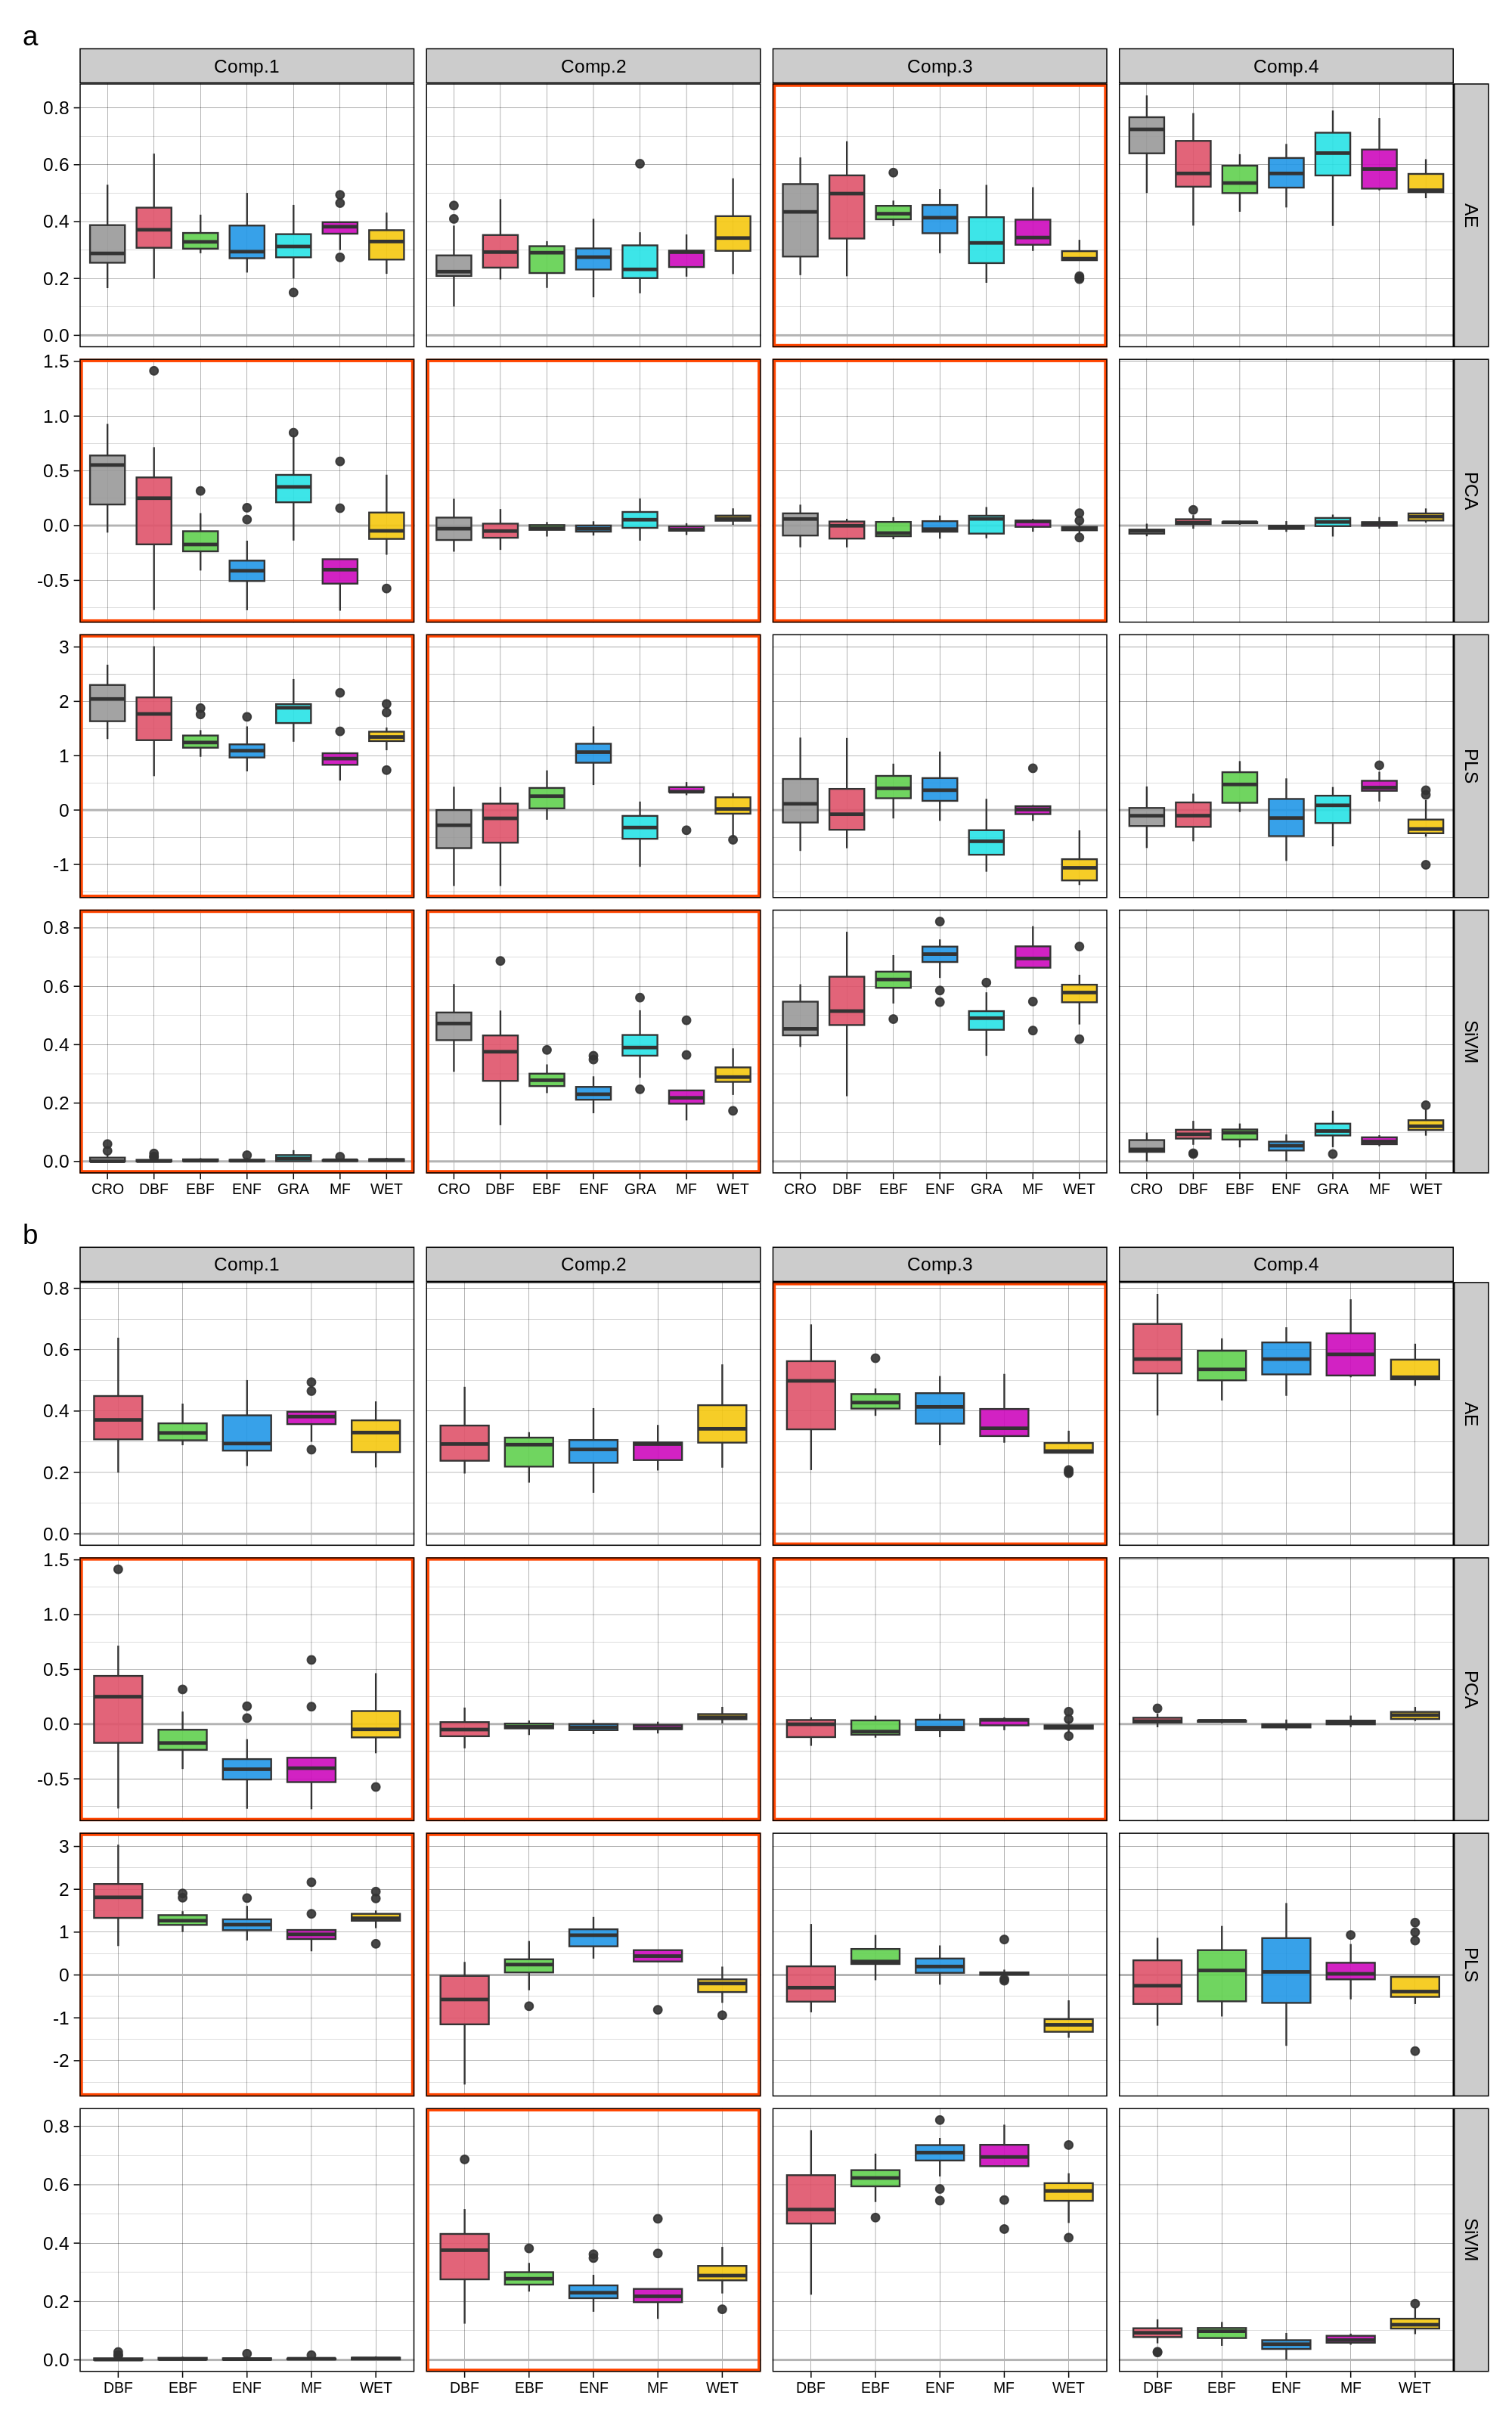

In [31]:
r4col <- unname(palette.colors(7, palette='R4'))
r4col[1] <- '#999999'
ix_4c2 <- which((grepl('04', tasknames, fixed=T) & !grepl('NIRvP', tasknames, fixed=T)))
score_dfs <- vector(mode='list', length=length(ix_4c2))

for (i in seq_along(ix_4c2)) {
    if (i < 7) {
        score_df <- models[[ix_4c2[i]]]$learner$graph_model$pipeops$comps$.result$output$data()[, -1] %>%
            rename('Comp.1'='comp01', 'Comp.2'='comp02', 'Comp.3'='comp03', 'Comp.4'='comp04')
    } else {
        score_df <- data.frame(models[[ix_4c2[i]]]$graph_model$state$regr.pls$model$scores[])
    }
    score_df$eco <- tasks[[ix_4c2[i]]]$data()$ecosystem
    gname <- sub('^DR_([^_]*).*', '\\1', tasknames[ix_4c2[i]])
    score_df$dr <- gsub('^(\\D+).*', '\\1', gsub('_.*', '', gname))
    score_df$group <- ifelse(grepl('_extES', gname, fixed=T), 'CRO & GRA sites excluded', 'All ecosystems')
    score_dfs[[i]] <- score_df}
names(score_dfs) <- tasknames[ix_4c2]
scores <- bind_rows(score_dfs)
scores$dr <- factor(scores$dr, levels=c('AE', 'SiVM', 'PCA', 'PLS'))
scores$group <- as.factor(scores$group)

scores_l <- scores %>%
  pivot_longer(cols=c(Comp.1, Comp.2, Comp.3, Comp.4), names_to = 'component', values_to = 'score')
scores_l_all <- scores_l %>% filter(group == 'All ecosystems')
scores_l_ext <- scores_l %>% filter(group == 'CRO & GRA sites excluded')


outline <- data.frame(id = factor(c('1', '2', '3', '4', '5', '6', '7', '8')),
    component = c('Comp.3', 'Comp.1', 'Comp.2', 'Comp.1', 'Comp.2', 'Comp.3', 'Comp.1', 'Comp.2'),
    dr = c('AE', 'SiVM', 'SiVM', 'PCA', 'PCA', 'PCA', 'PLS', 'PLS'), oc = 'orangered')

boxp_all <- ggplot(scores_l_all, aes(x=eco, y=score, fill=eco)) +
    geom_hline(yintercept=0, color='grey70') +
    geom_boxplot(alpha=.9, lwd=.4) +
    scale_fill_manual(values=r4col, 'black') +
    geom_rect(data = outline, aes(xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf),
              fill=NA, color='orangered', inherit.aes=FALSE, linewidth=1.5) +
    facet_grid(dr~component, space='fixed', scales='free') +
    labs(x = NULL, y = NULL) + theme_linedraw() +
    theme(axis.text.x=element_text(size=7),
        axis.title=element_text(size=11),
        legend.position='none',
        plot.title.position = 'plot',
        strip.background=element_rect(fill='grey80'),
        strip.text=element_text(color = 'black'))
boxp_ext <- ggplot(scores_l_ext, aes(x=eco, y=score, fill=eco)) +
    geom_hline(yintercept=0, color='grey70') +
    geom_boxplot(alpha=.9, lwd=.4) +
    scale_fill_manual(values=r4col[-c(1,5)]) +
    geom_rect(data = outline[-2,], aes(xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf),
              fill=NA, color='orangered', inherit.aes=FALSE, linewidth=1.5) +
    facet_grid(dr~component, space='fixed', scales='free') +
    labs(x = NULL, y = NULL) + theme_linedraw() +
    theme(axis.text.x=element_text(size=7),
        axis.title=element_text(size=11),
        legend.position='none',
        plot.title.position = 'plot',
        strip.background=element_rect(fill='grey80'),
        strip.text=element_text(color = 'black'))

fig(10, 16, 40, 200)
boxp <- patchwork::wrap_plots(boxp_all, boxp_ext, widths = c(1,1), heights = c(1,1), ncol=1) +
    plot_annotation(tag_levels = 'a')
boxp
#ggsave(file.path(plotdir, 'dr_scores_grid.png'),
#       boxp, device='png', width=14, height=20, units='cm', dpi=300, scale=1.5) # here scale is useful to adjust point size

### Residual scatterplots

In [6]:
r4col <- unname(palette.colors(7, palette='R4'))
r4col[1] <- '#999999'

ps_res <- vector(mode='list', length=length(combi))
dalex_mds  <- vector(mode='list', length=length(combi))

for (i in 1:length(combi)) {
    dalex_md <- model_diagnostics(dalex_exps[[i]])
    dalex_md['eco'] <- flx_gdfs[[i]]$ecosystem
    dalex_mds[[i]] <- dalex_md

    p_res <- ggplot(data=dalex_md, aes(x=y_hat, y=residuals)) +
        geom_point(mapping=aes(fill=eco), shape=21, size=1.5, stroke=.3, alpha=.9) +
        scale_fill_manual(values=unname(r4col), guide=guide_legend(title=NULL)) +
        scale_x_continuous(breaks=seq(0, 35, 10)) +
        scale_y_continuous(expand=expansion(mult=c(.13, .05))) +
        geom_smooth(method='loess', se=F, color='grey60', linewidth=.5) +
        xlab(expression("predicted GPP"~group("[",µmol~CO[2]~m^{-2}~h^{-1},"]"))) +
        guides(fill=guide_legend(title=element_blank(), nrow=1, byrow=TRUE),
               color=guide_legend(override.aes=list(fill=NA))) +
        theme_linedraw() +
        theme(axis.text=element_text(size=8),
              axis.title=element_text(size=9),
              legend.spacing.x=unit(0, 'mm'), legend.spacing.y=unit(0, 'mm'),
              legend.position=c(.5, .056), legend.margin=margin(c(0,3,0,4)),
              legend.background = element_rect(colour='black', fill=alpha('white', 0.7),
                                               linetype='solid', linewidth=.25),
              legend.key=element_rect(colour=NA, fill=NA),
              legend.text=element_text(size=6), legend.title=element_blank(),
              plot.margin=margin(r=0, unit='pt')) # for joining with density plot
    
    p_dens <- ggplot(dalex_md, aes(x=residuals)) +
        geom_density() + coord_flip() +
        scale_x_continuous(expand=expansion(mult=c(.13, .05))) +
        scale_y_continuous(breaks = seq(0, 1, by=.1)) +
        theme_linedraw() +
        theme(axis.text=element_text(size=8),
              axis.title=element_text(size=9),
              panel.grid.minor.x = element_blank(),
              axis.text.y=element_blank(),
              axis.ticks.y=element_blank(),
              axis.title.y=element_blank(),
              plot.margin=margin(l=0, unit='pt'))
    ps_res[[i]] <- p_res + p_dens + plot_layout(nrow = 1, widths = c(.875, .125))
    #ggsave(plotdir, sprintf('resids+density_%s.png', tasknames[i])),
    #       ps_res[[i]], device='png', scale=1, width=12, height=7, units='cm', dpi=300)
    }


`geom_smooth()` using formula = 'y ~ x'


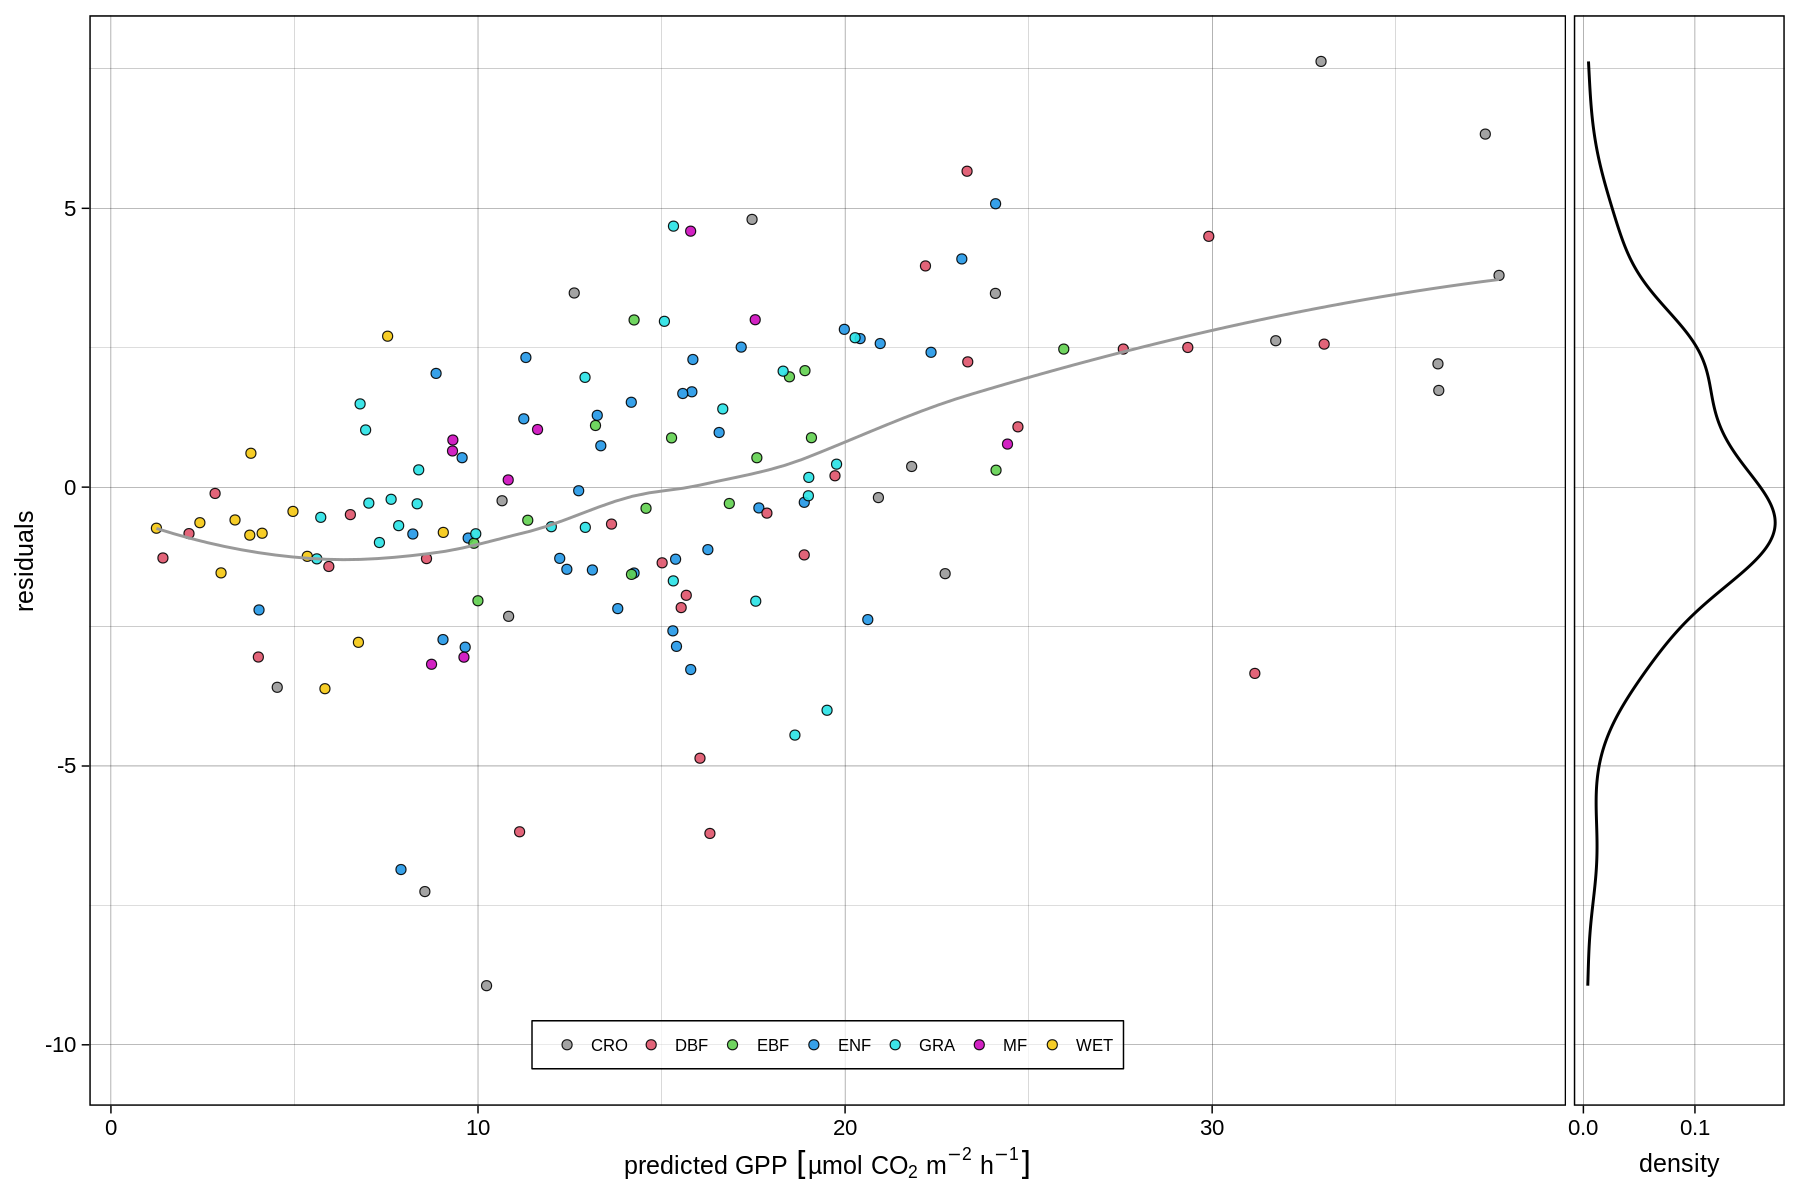

In [13]:
fig(9, 6, 40, 200)
ps_res[[1]]

Warning message:
“The dot-dot notation (`..scaled..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(scaled)` instead.”
`geom_smooth()` using formula = 'y ~ x'


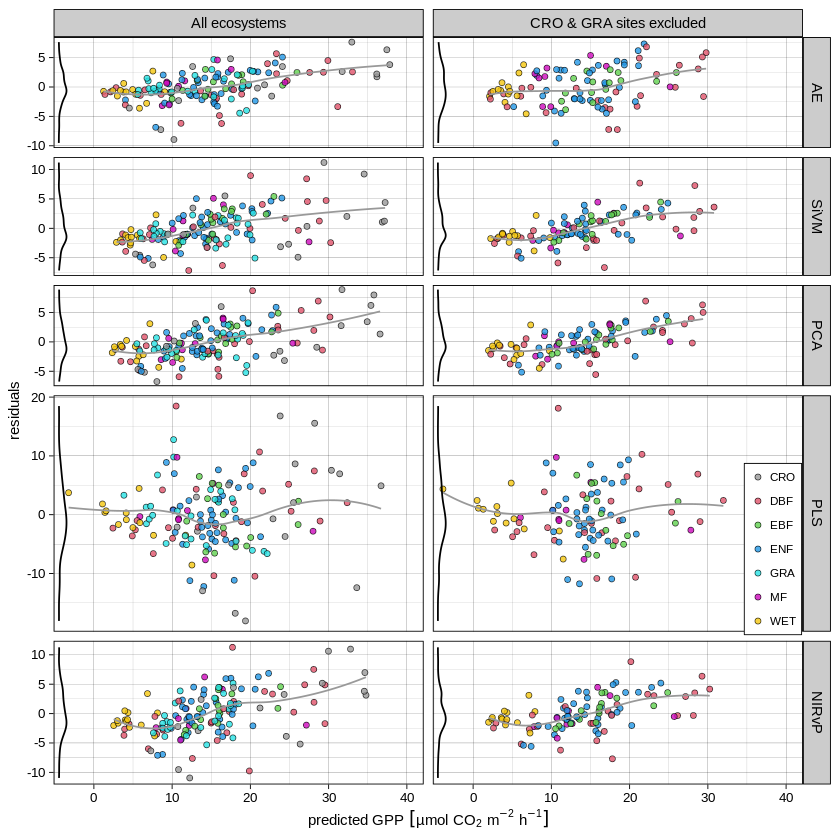

In [7]:
#dalex_md_4c_dfs
ix_4c2 <- which((grepl('04', tasknames, fixed=T) | grepl('NIRvP', tasknames, fixed=T)))
dalex_md_4c_dfs <- vector(mode='list', length=length(ix_4c2))

for (i in seq_along(ix_4c2)) {
    dalex_md_4c_df <- dalex_mds[[ix_4c2[i]]][, c('y_hat', 'residuals', 'eco')]
    gname <- sub('^DR_([^_]*).*', '\\1', tasknames[ix_4c2[i]])
    dalex_md_4c_df$dr <- gsub('^(\\D+).*', '\\1', gsub('_.*', '', gname))
    dalex_md_4c_df$group <- ifelse(grepl('_extES', gname, fixed=T), 'CRO & GRA sites excluded', 'All ecosystems')
    dalex_md_4c_dfs[[i]] <- dalex_md_4c_df
}
names(dalex_md_4c_dfs) <- tasknames[ix_4c2]
dalex_md_4c <- bind_rows(dalex_md_4c_dfs)
dalex_md_4c$dr <- factor(dalex_md_4c$dr, levels=c('AE', 'SiVM', 'PCA', 'PLS', 'NIRvP'))
dalex_md_4c$group <- as.factor(dalex_md_4c$group)

p_res_4c <- ggplot(data=dalex_md_4c, aes(x=y_hat, y=residuals)) +
    geom_point(mapping=aes(fill=eco), shape=21, size=1.5, stroke=.3, alpha=.8) +
    scale_fill_manual(values=unname(r4col), guide=guide_legend(title=NULL)) +
    geom_smooth(method='loess', se=F, color='grey60', linewidth=.5) +
    stat_density(aes(y=residuals, x=(-4.5+(..scaled..))), # add density to left edge of each scatterplot
                 position='identity', geom='line') +
    xlab(expression("predicted GPP"~group("[",µmol~CO[2]~m^{-2}~h^{-1},"]"))) +
    facet_grid(dr~group, space='free', scales='free') +
    coord_cartesian(xlim = c(-3,40)) +
    theme_linedraw() +
    theme(axis.text=element_text(size=8),
          axis.title=element_text(size=9),
          legend.spacing.x=unit(0, 'mm'), legend.spacing.y=unit(0, 'mm'),
          legend.position=c(.96, .315), legend.margin=margin(c(1,3,1,1)),
          legend.background = element_rect(colour='black', fill='white',
                                           linetype='solid', linewidth=.25),
          legend.key=element_rect(colour=NA, fill=NA),
          legend.key.size=unit(1, 'lines'),
          legend.text=element_text(size=7), legend.title=element_blank(),
          strip.background=element_rect(fill='grey80'),
          strip.text=element_text(color='black'))

#fig(9, 6, 40, 200)
p_res_4c
#ggsave(file.path(plotdir, 'resids+density_4c+extES_grid.png'),
#       p_res_4c, device='png', width=22, height=20, units='cm', dpi=300)

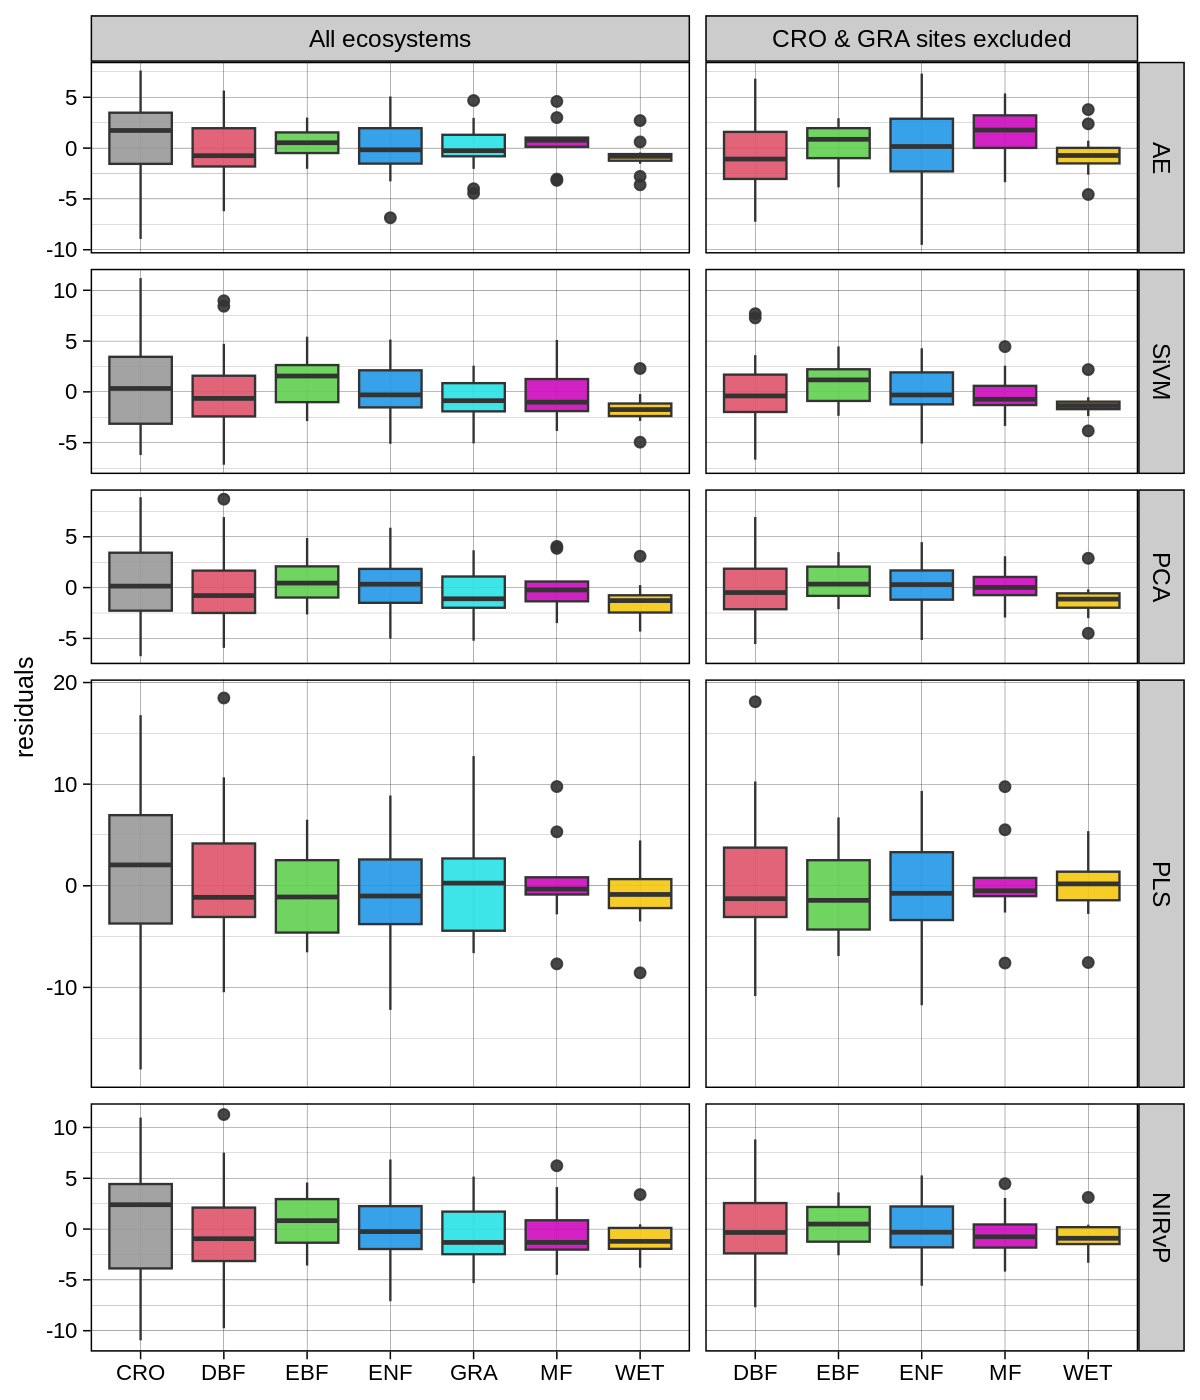

In [23]:
bp_res_4c <- ggplot(data=dalex_md_4c, aes(x=eco, y=residuals)) +
    geom_boxplot(mapping=aes(fill=eco), alpha=.9, lwd=.4) +
    scale_fill_manual(values=unname(r4col), guide=guide_legend(title=NULL)) +
    xlab(expression("predicted GPP"~group("[",µmol~CO[2]~m^{-2}~h^{-1},"]"))) +
    facet_grid(dr~group, space='free', scales='free') +
    labs(x = NULL) + theme_linedraw() +
    theme(axis.text=element_text(size=8),
          axis.title=element_text(size=9),
          legend.position='none',
          strip.background=element_rect(fill='grey80'),
          strip.text=element_text(color='black'))

bp_res_4c
fig(6, 7, 40, 200)
#ggsave(file.path(plotdir, 'resids_eco_bp_4c+extES_grid.png'),
#       bp_res_4c, device='png', width=18, height=14, units='cm', dpi=300)

### Residual boxplot of all models

In [34]:
resids_dfs <- lapply(dalex_exps, model_performance)
resids_dfs <- lapply(1:length(combi), function(x) {resids_dfs[[x]]$residuals})

for (i in 1:length(combi)) {
    if (grepl('^AE', tasknames[i])) {
        resids_dfs[[i]]$group <- 'AE'
    } else if (grepl('^SiVM', tasknames[i])) {
        resids_dfs[[i]]$group <- 'SiVM'
    } else if (grepl('^PCA', tasknames[i])) {
        resids_dfs[[i]]$group <- 'PCA'
    } else if (grepl('^PLS', tasknames[i])) {
        resids_dfs[[i]]$group <- 'PLS'
    } else if (grepl('^NIR', tasknames[i])) {
        resids_dfs[[i]]$group <- 'NIRvP'
    }
}
names(resids_dfs) <- tasknames
resids <- bind_rows(resids_dfs)
resids$group <- factor(resids$group, levels=unique(resids$group))
resids$label <- factor(resids$label, levels=rev(unique(resids$label)))

In [35]:
r4col <- unname(palette.colors(7, palette='R4'))[3:7]
fig(9, 6, 40, 200)

p_res_box <- ggplot(resids, aes(x=label, y=abs(diff))) +
    geom_boxplot(aes(fill=group), outlier.size=1, outlier.alpha=.7) +
    coord_flip() +
    scale_x_discrete(breaks=resids$label, labels=gsub('^.{0,6}', '', resids$label)) +
    #scale_y_continuous(trans='sqrt') +
    scale_fill_manual(values=r4col) +
    guides(fill='none') +
    ylab('absolute residuals') + xlab('model') +
    theme_bw() + theme(plot.title=element_blank(),
                       plot.subtitle=element_blank(),
                       panel.grid.major.y=element_blank()) +
    facet_grid(group~., scales='free_y', space='free_y')

#ggsave(file.path(plotdir, 'resids_boxplot_all_models.png'),
#       p_res_box, device='png', width=14, height=11, units='cm', dpi=300)

### Loadings & archetypes
In a first step, PLS loadings are exported to the same folder as PCA loadings and SiVM archetypes generated in the Python DR pipeline.

In [36]:
wl_vector <- rownames(read.csv(file.path(wdir0, 'data', 'dr_files', 'DR_PCA04_PRISMA_loadings_matrix.csv'),
                               header=TRUE, row.names=1, check.names=FALSE))
drs <- c('PLS04', 'PLS10', 'PLS20')
for (i in seq_along(drs)) {
    nc <- as.numeric(substr(drs[i], 4,5))
    plsloads <- data.frame(models[[which(tasknames==drs[i])]]$graph_model$state$regr.pls$model$loadings[1:66, 1:nc])
    colnames(plsloads) <- sprintf('Comp%02d', 1:nc)
    rownames(plsloads) <- wl_vector
    write.csv(plsloads, sprintf(paste0(wdir0, '/data/dr_files/DR_%s_PRISMA_loadings_matrix.csv'), drs[i]))
}

Load weights 1 (input -> hidden layer), weights 2 (hidden layer -> code layer) and bias matrix auf the autoencoders with 4 and 10 components.

In [37]:
ae_fnames = c('DR_AE04_050epoch_PRISMA_w1+bias_matrix', 'DR_AE10_050epoch_PRISMA_w1+bias_matrix',
              'DR_AE04_050epoch_PRISMA_w2_matrix', 'DR_AE10_050epoch_PRISMA_w2_matrix')
nr <- length(ae_fnames)/2
w1_dfs <- vector(mode='list', length=nr)
w2_dfs <- vector(mode='list', length=nr)
b1 <- vector(mode='list', length=nr)
gnames <- vector(mode='list', length=nr)

for (i in seq(1,nr)) {
    w1_df <- read.csv(sprintf('%s/%s/%s.csv', wdir0, 'data/dr_files', ae_fnames[i]), header=TRUE, row.names=1, check.names=FALSE)
    neucols <- colnames(w1_df)
    gnames[i] <- sub('^DR_([^_]*).*', '\\1', ae_fnames[i])
    b1[[i]] <- unlist(w1_df[dim(w1_df)[1], ])
    w1_df <- w1_df[1:(dim(w1_df)[1]-1), ]
    w1_df$wl <- rownames(w1_df)
    w1_df$group <- paste0('comps', gsub('.*?([0-9]+).*', '\\1', gnames[i]))
    w1_df$dr <- gsub('.{2}$', '', gnames[i])
    w1_dfs[[i]] <- pivot_longer(w1_df, cols=all_of(neucols), names_to='neuron', values_to='value') %>%
        mutate(pvalue = percent_rank(value))
    
    w2_df <- read.csv(sprintf('%s/%s/%s.csv', wdir0, 'data/dr_files', ae_fnames[i+nr]), header=TRUE, row.names=1, check.names=FALSE)
    compcols <- colnames(w2_df)
    w2_df$neu <- rownames(w2_df)
    w2_df$group <- paste0('comps', gsub('.*?([0-9]+).*', '\\1', gnames[i]))
    w2_dfs[[i]] <- pivot_longer(w2_df, cols=all_of(compcols), names_to='comp', values_to='value') %>%
        mutate(pvalue = percent_rank(value))
    }
names(w1_dfs) <- gnames
w1_all <- bind_rows(w1_dfs)
w1_all$neuron <- factor(w1_all$neuron, levels=unique(w1_all$neuron))
w1_all$group <- factor(w1_all$group, levels=unique(w1_all$group))
w1_all$dr <- factor(w1_all$dr, levels=unique(w1_all$dr))
w1_all$wl <- factor(w1_all$wl, levels=unique(w1_all$wl))
names(w2_dfs) <- gnames
w2_all <- bind_rows(w2_dfs)
w2_all$comp <- factor(w2_all$comp, levels=unique(w2_all$comp))
w2_all$group <- factor(w2_all$group, levels=unique(w2_all$group))
w2_all$neu <- factor(w2_all$neu, levels=unique(w2_all$neu))

Now the base matrices of all other DR methods are loaded and concatenated into a long data.frame for plotting (including the AE weight matrix 1 but not 2 since it has different dimensions).

In [38]:
fnames = c('DR_PCA04_PRISMA_loadings_matrix', 'DR_PCA10_PRISMA_loadings_matrix', 'DR_PCA20_PRISMA_loadings_matrix',
           'DR_PLS04_PRISMA_loadings_matrix', 'DR_PLS10_PRISMA_loadings_matrix', 'DR_PLS20_PRISMA_loadings_matrix',
           'DR_SiVM04_distm-l2_PRISMA_base_matrix', 'DR_SiVM10_distm-l2_PRISMA_base_matrix', 'DR_SiVM20_distm-l2_PRISMA_base_matrix')
base_dfs <- vector(mode='list', length=9)
gnames <- vector(mode='list', length=9)

for (i in seq_along(fnames)) {
    base_df <- read.csv(sprintf('%s/%s/%s.csv', wdir0, 'data/dr_files', fnames[i]),
                        header=TRUE, row.names=1, check.names=FALSE)
    compcols <- colnames(base_df)
    gnames[i] <- sub('^DR_([^_]*).*', '\\1', fnames[i])
    base_df$wl <- rownames(base_df)
    base_df$group <- paste0('comps', gsub('.*?([0-9]+).*', '\\1', gnames[i]))
    base_df$dr <- gsub('.{2}$', '', gnames[i])
    base_dfs[[i]] <- pivot_longer(base_df, cols=all_of(compcols), names_to='comp', values_to='value') %>%
        mutate(pvalue = percent_rank(value))
}
names(base_dfs) <- gnames
all_bases <- bind_rows(base_dfs)
all_bases$comp <- factor(all_bases$comp, levels=unique(all_bases$comp))
all_bases$group <- factor(all_bases$group, levels=unique(all_bases$group))
all_bases$dr <- factor(all_bases$dr, levels=unique(all_bases$dr))
all_bases$wl <- factor(all_bases$wl, levels=unique(all_bases$wl))

# filter out unwanted groups and methods
all_bases %>% filter(group != 'comps20') %>% filter(dr != 'PLS') -> all_bases_final
all_bases_ae <- bind_rows(list(rename(w1_all, comp=neuron), all_bases_final))

Create ggplot objects for the different methods that will eventually be combined with the `patchwork` package.

In [39]:
# PCA loadings and SiVM bases plots
pcax_list <- list(c(1,2,3), c(1,2,3)) # PCA04 -> relC=3,2,1; PCA10 -> relC=2,3,1
sivmx_list <- list(c(1,2), c(2,6,10)) # SiVM04 -> relC=2,1; SiVM10 -> relC=10,6,2
pca_ps <- vector(mode='list', length=length(pcax_list))
sivm_ps <- vector(mode='list', length=length(sivmx_list))

xsize <- length(unique(all_bases$wl))

for (i in seq_along(pca_ps)) {
    all_bases %>% filter(group == levels(all_bases$group)[i] & dr == 'PCA') -> pca_data
    pca_ps[[i]] <- local({ # local wrap needed to make ggplot NOT use the last value of i for ALL plots
        i <- i
        nl <- length(pcax_list[[i]])
        ggplot(pca_data) +
        geom_tile(aes(x=wl, y=comp, fill=pvalue)) +
        scale_fill_viridis(guide = 'none') +
        {if(i==2) scale_y_discrete(breaks = levels(sivm_data$comp)[c(T, F, F)])} +
        scale_x_discrete(breaks = levels(pca_data$wl)[c(T, rep(F, 11))]) +
        geom_rect(data = data.frame(group=rep(levels(pca_data$group)[i], nl)),
                  aes(xmin=rep(.5, nl), xmax=rep(xsize + .5, nl), # this stays always the same, only rep changes!
                      ymin=pcax_list[[i]] - .5, ymax=pcax_list[[i]] + .5),
                  fill=NA, color='orangered', inherit.aes = FALSE, linewidth=1.1) +
        theme_dark() + theme(plot.title=element_blank(),
                             plot.subtitle=element_blank(),
                             panel.grid.major.y=element_blank(),
                             axis.title=element_blank())
    })
    all_bases %>% filter(group == levels(all_bases$group)[i] & dr == 'SiVM') -> sivm_data
    sivm_ps[[i]] <- local({ # local wrap needed to make ggplot NOT use the last value of i for ALL plots
        i <- i
        nl <- length(sivmx_list[[i]])
        ggplot(sivm_data) +
        geom_tile(aes(x=wl, y=comp, fill=pvalue)) +
        scale_fill_viridis(guide = 'none') +
        {if(i==2) scale_y_discrete(breaks = levels(sivm_data$comp)[c(T, F, F)])} +
        scale_x_discrete(breaks = levels(sivm_data$wl)[c(T, rep(F, 11))]) +
        geom_rect(data = data.frame(group=rep(levels(sivm_data$group)[i], nl)),
                  aes(xmin=rep(.5, nl), xmax=rep(xsize + .5, nl), # this stays always the same, only rep changes!
                      ymin=sivmx_list[[i]] - .5, ymax=sivmx_list[[i]] + .5),
                  fill=NA, color='orangered', inherit.aes = FALSE, linewidth=1.1) +
        #xlab('Wavelength') +
        theme_dark() + theme(plot.title=element_blank(),
                             plot.subtitle=element_blank(),
                             panel.grid.major.y=element_blank(),
                             axis.title=element_blank())
    })
    }
#fig(6, 2, 40, 200)
#pca_ps[[1]]

In [40]:
# AE weights plots
w1_ps <- vector(mode='list', length=length(w1_dfs))
w2_ps <- vector(mode='list', length=length(w2_dfs))
# rectangles: relevant neurons are <10perc & >90perc
# AE04 -> relC=3 -> relN3=(4,6,10,12,13),
# AE10 -> relC=2,5 -> relN2=(8,9), relN5(6,23)
nx_list <- list(c(4,6,10,12,13), c(6,8,9,23))
ny_list <- list(c(3,3,3,3,3), c(5,2,2,5))

for (i in seq_along(w2_dfs)) {
    w1_all %>% filter(group == levels(w2_all$group)[i]) -> w1_data
    w1_ps[[i]] <- local({ # local wrap needed to make ggplot NOT use the last value of i for ALL plots
        i <- i
        nl <- length(nx_list[[i]])
        xsize <- length(unique(w1_dfs[[i]]$wl))
        ggplot(w1_data) +
        geom_tile(aes(x=wl, y=neuron, fill=pvalue)) +
        scale_fill_viridis(guide = guide_colourbar()) +
        scale_y_discrete(breaks = levels(w1_data$neuron)[c(T, F, F)]) +
        scale_x_discrete(breaks = levels(w1_data$wl)[c(T, rep(F, 11))]) +
        geom_rect(data = data.frame(group=rep(levels(w2_all$group)[i], nl)),
                  aes(xmin=rep(.5, nl), xmax=rep(xsize + .5, nl), # this stays always the same, only rep changes!
                      ymin=nx_list[[i]] - .5, ymax=nx_list[[i]] + .5),
                  fill=NA, color='orangered', inherit.aes = FALSE) +
        guides(fill='none') +
        theme_dark() + theme(plot.title=element_blank(),
                             plot.subtitle=element_blank(),
                             panel.grid.major.y=element_blank(),
                             axis.title=element_blank())
    })
    w2_all %>% filter(group == levels(w2_all$group)[i]) -> w2_data
    #if (i == 1) {print(filter(w2_data, comp == 'Comp03'), n=60)}
    #if (i == 2) {print(filter(w2_data, comp %in% c('Comp05', 'Comp02')), n=60)}
    w2_ps[[i]] <- local({
        i <- i
        nl <- length(nx_list[[i]])
        xsize <- length(unique(w1_dfs[[i]]$neuron))
        ggplot(w2_data) +
        geom_tile(aes(x=neu, y=comp, fill=pvalue)) +
        scale_fill_viridis(guide = guide_colourbar()) +
        {if(i==2) scale_y_discrete(breaks = levels(sivm_data$comp)[c(T, F, F)])} +
        {if(i==1) scale_x_discrete(breaks = levels(w2_data$neu)[c(T, rep(F, 7))])
         else scale_x_discrete(breaks = levels(w2_data$neu)[c(T, rep(F, 11))])} +
        geom_rect(data = data.frame(group=rep(levels(w2_all$group)[i], nl)),
                  aes(xmin=nx_list[[i]] - .5, xmax=nx_list[[i]] + .5,
                      ymin=ny_list[[i]] - .5, ymax=ny_list[[i]] + .5), # this depends on nr of relevant comps
                  fill=NA, color='orangered', inherit.aes = FALSE, linewidth=1) +
        guides(fill='none') +
        theme_dark() + theme(plot.title=element_blank(),
                             plot.subtitle=element_blank(),
                             panel.grid.major.y=element_blank(),
                             axis.title=element_blank())
        })
    }
#fig(6, 2, 40, 200)
#w1_ps[[2]]

In [41]:
# Example green vegetation spectra plot
spectra <- H5File$new(file.path(wdir0, 'DR_hsi_transp_PRISMA_bg_ref.h5'), mode='r')
exp_spec <- spectra[['ds1']][1:66, 200579] # 200579 -> Single spectra from DE-HoH dataTake on 2021-05-24: Green forest reflectance
spectra$close_all()
exp_spec_df <- data.frame(wl=as.numeric(wl_vector), exp_spec)
p_spec <- ggplot(exp_spec_df, aes(x=wl, y=exp_spec)) +
    #geom_line(aes(x=wl, y=exp_spec), color='blue') +
    stat_smooth(aes(x=wl, y=exp_spec, color='orangered'), method=lm, formula = y~poly(x, 16), se = FALSE) +
    scale_x_continuous(breaks = as.numeric(levels(all_bases_ae$wl)[c(T, rep(F, 6))]), expand = c(0, 0)) +
    xlab('') + ylab('Reflectance') + guides(color='none') +
    theme_linedraw() + theme(plot.title=element_blank(),
                             plot.subtitle=element_blank(),
                             axis.text.x=element_blank(),
                             panel.grid.major.y=element_blank())
#fig(6, 2, 40, 200)
#p_spec

In [42]:
# Create tile plots for PCA loadings, SiVM bases and AE weights 1 for 4 & 10 comp variants in facet

# rectangles: relevant neurons are <10perc & >90perc
# AE04 -> relC=3 -> relN3=(4,6,10,12,13); AE10 -> relC=2,5 -> relN2=(8,9), relN5(6,23)
aex_list <- list(c(4,6,10,12,13), c(6,8,9,23))
#aey_list <- list(c(3,3,3,3,3), c(5,2,2,5))
pcax_list <- list(c(1,2,3), c(1,2,3)) # PCA04 -> relC=3,2,1; PCA10 -> relC=2,3,1
sivmx_list <- list(c(1,2), c(2,6,10)) # SiVM04 -> relC=2,1; SiVM10 -> relC=10,6,2
allx_list <- c(aex_list, pcax_list, sivmx_list)

xl <- vector(mode='numeric', length=length(allx_list))
for (i in seq_along(c(aex_list, pcax_list, sivmx_list))) {
    xl[i] <- length(allx_list[[i]])
}

mock_data <- data.frame(group=c(rep('comps04', xl[1]), rep('comps10', xl[2]), rep('comps04', xl[3]),
                                rep('comps10', xl[4]), rep('comps04', xl[5]), rep('comps10', xl[6])),
                        dr=c(rep('AE', xl[1]+xl[2]), rep('PCA', xl[3]+xl[4]), rep('SiVM', xl[5]+xl[6])),
                        xlim=unlist(allx_list))

facet_labs <- as_labeller(c('comps04'='4 comp.', 'comps10'='10 comp.',
                             'AE'='Autoencoder', 'PCA'='PCA', 'SiVM'='SiVM'))
xsize <- length(unique(pca_data$wl))
p_wl <- ggplot(all_bases_ae) +
    geom_tile(aes(x=wl, y=comp, fill=pvalue)) +
    geom_rect(data = mock_data, fill=NA, color='orangered', inherit.aes=FALSE, linewidth=1.5,
              aes(xmin=rep(.5, nrow(mock_data)), xmax=rep(xsize + .5, nrow(mock_data)), ymin=xlim - .5, ymax=xlim + .5)) +
    scale_fill_viridis(guide = guide_colourbar(), name='Percentile  ', labels = scales::label_percent()) +
    scale_y_discrete(breaks = levels(all_bases_ae$comp)[c(T, F)]) +
    scale_x_discrete(breaks = levels(all_bases_ae$wl)[c(T, rep(F, 6))]) +
    xlab('Wavelength') + ylab('') +
    theme_linedraw() + theme(plot.title=element_blank(),
                         plot.subtitle=element_blank(),
                         panel.grid.major.y=element_blank(),
                         legend.key.width = unit(dev.size()[1] / 2, 'cm'),
                         legend.key.height = unit(dev.size()[1] / 20, 'cm'),
                         legend.position='bottom') +
    facet_grid(group+dr~., scales='free_y', space='free_y', labeller=facet_labs)
#fig(10, 14, 40, 200)
#p_wl

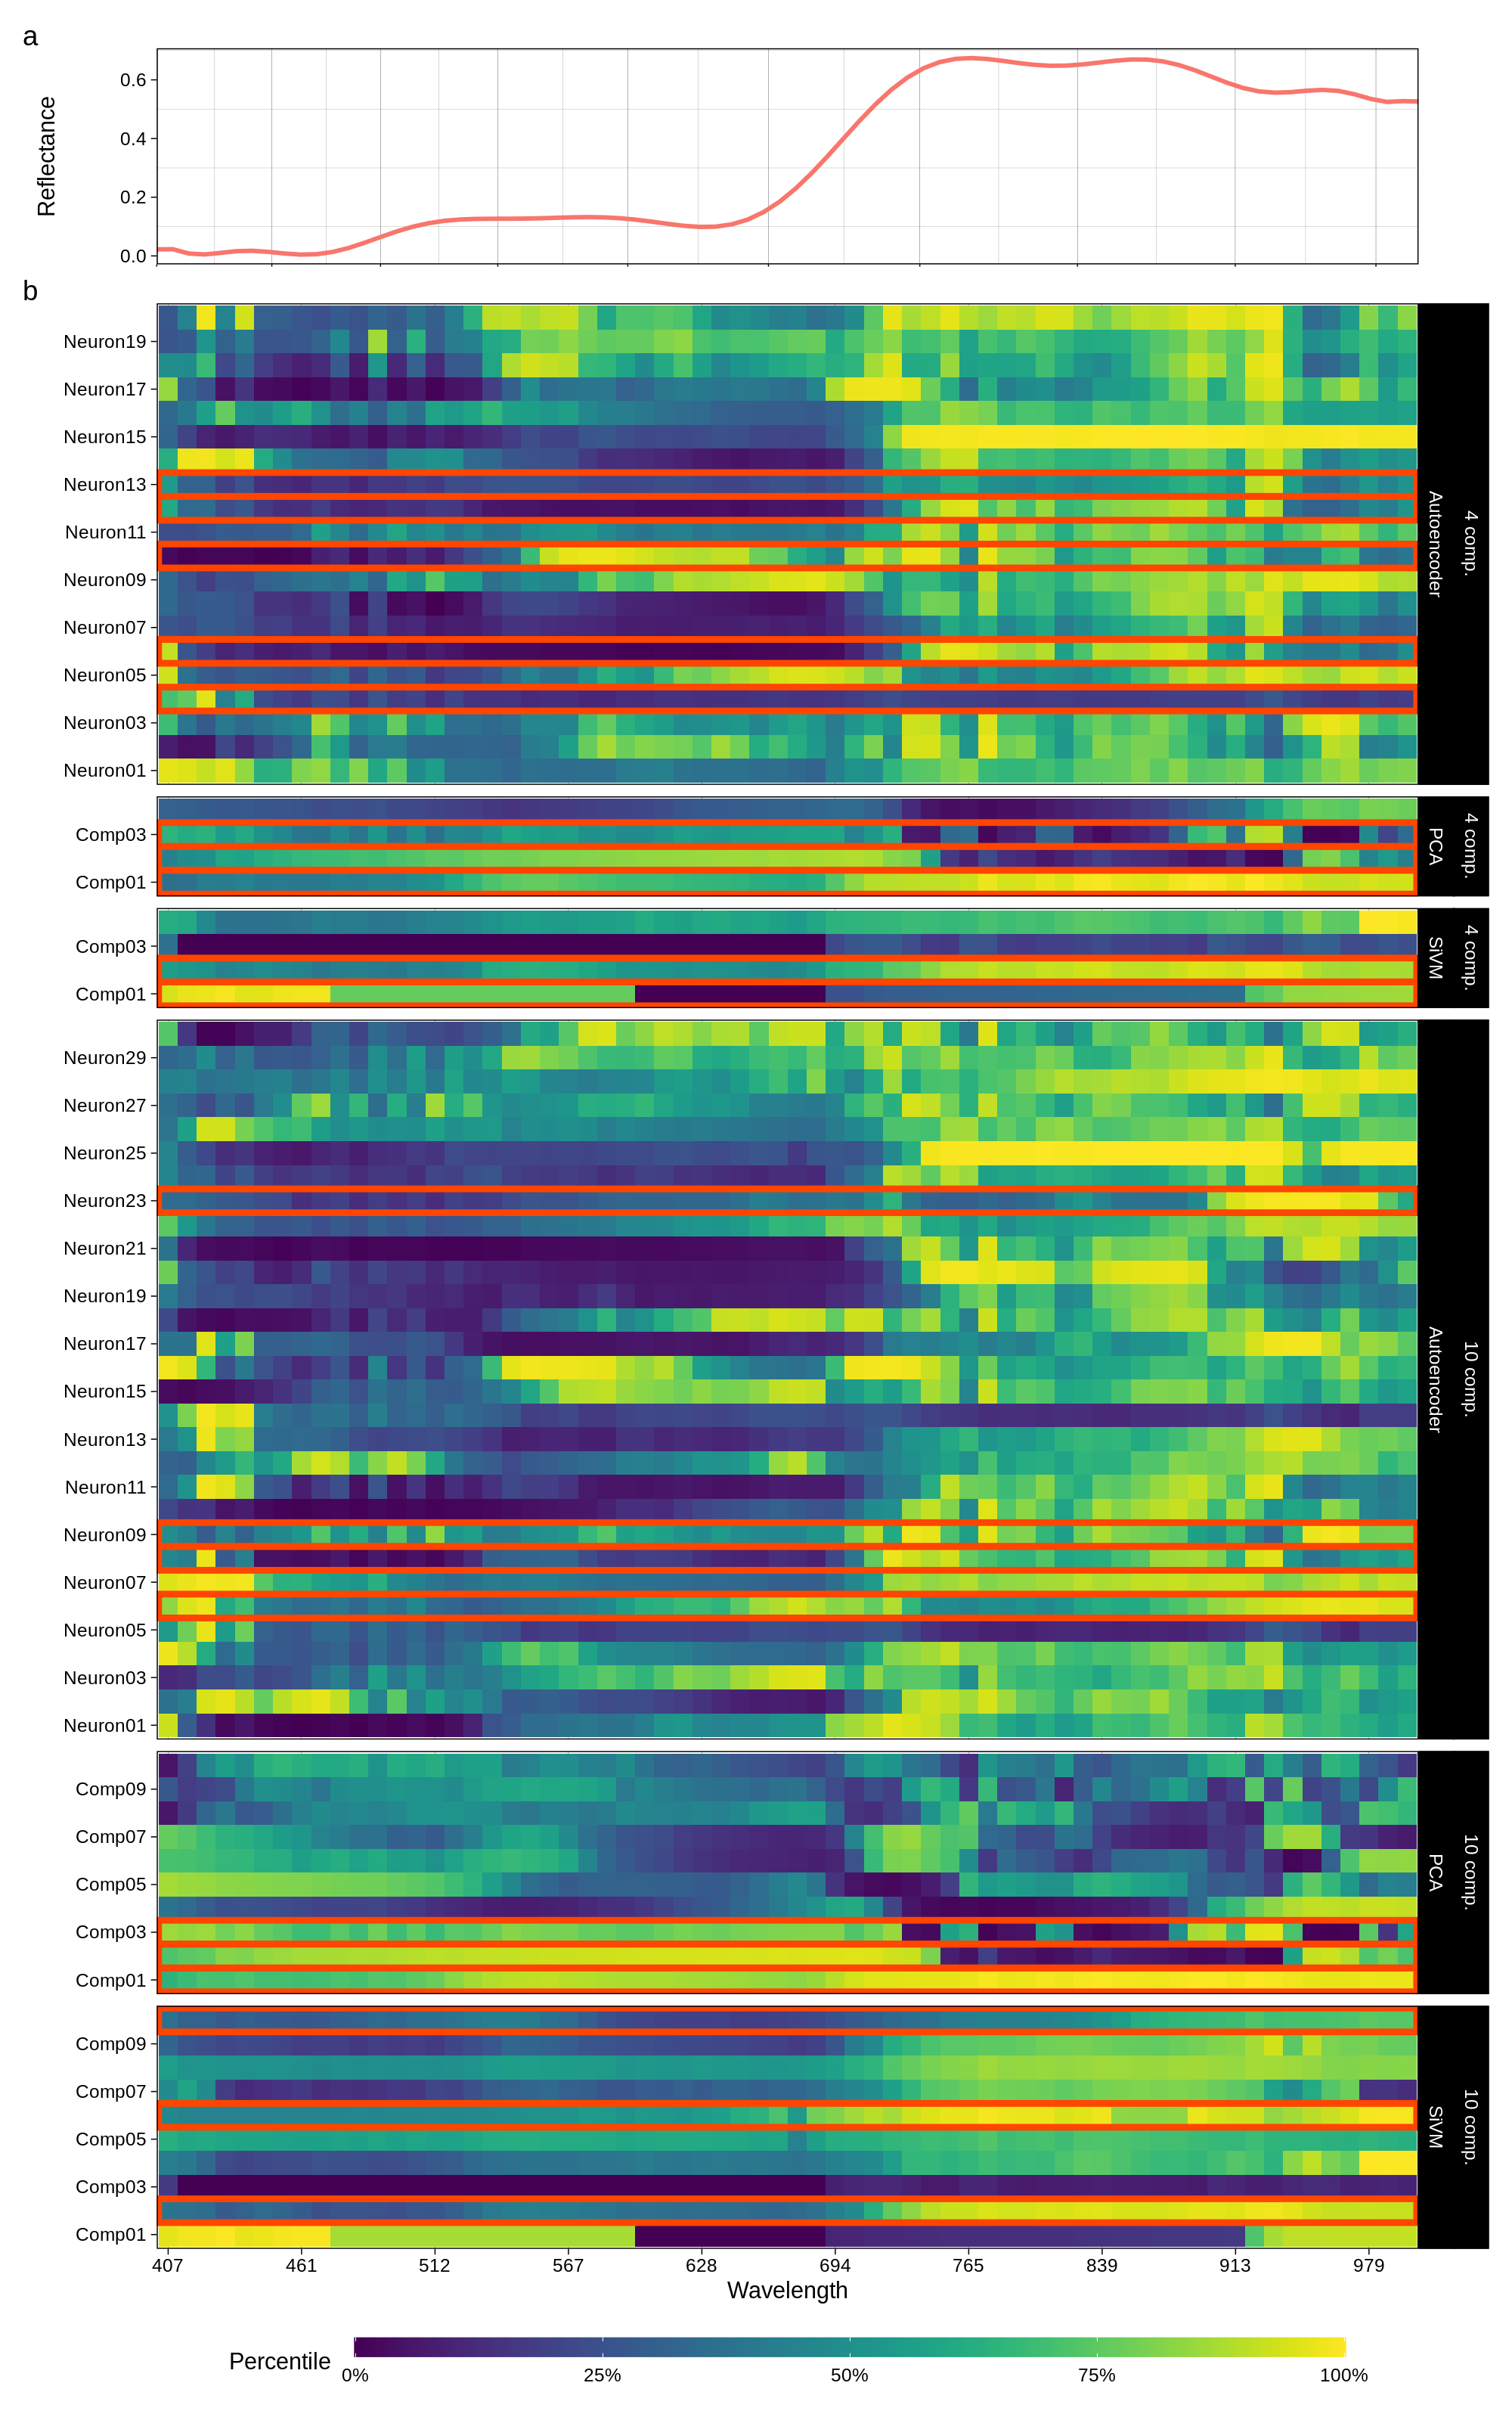

In [24]:
fig(10, 16, 40, 200)
p_all <- patchwork::wrap_plots(p_spec, plot_spacer(), p_wl, widths = c(1,1,1), heights = c(1,-.3,9), ncol=1) +
    plot_annotation(tag_levels = 'a')
p_all
#ggsave(file.path(plotdir, 'base_mats_4+10comp_spectrum.png'),
#       p_all, device='png', width=15, height=20, units='cm', dpi=300, scale=2) # here scale is useful to adjust point size

Now plot AE code layer weights and biases together.

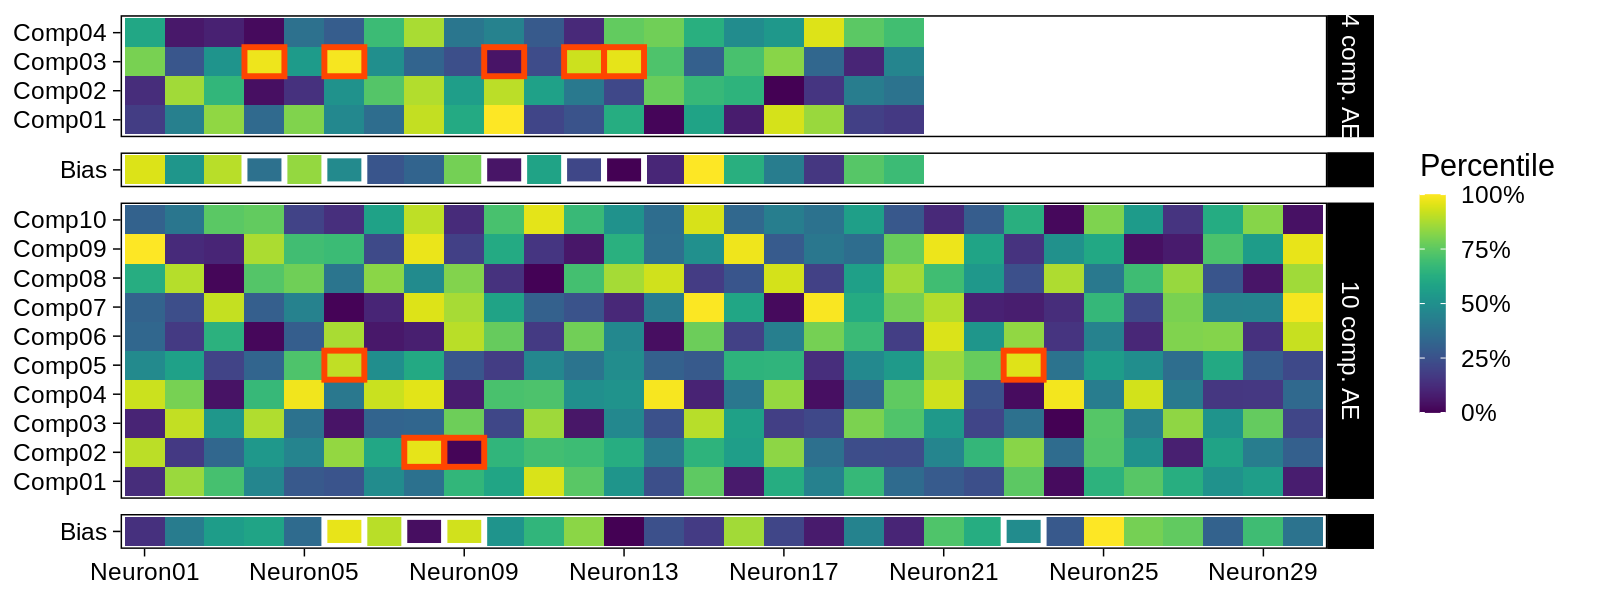

In [43]:
b1_df <- data.frame(neu=factor(names(b1[[1]])), group=factor('comps04bias'), comp=factor('Bias'),
                    value=b1[[1]]) %>% mutate(pvalue = percent_rank(value))
b2_df <- data.frame(neu=factor(names(b1[[2]])), group=factor('comps10bias'), comp=factor('Bias'),
                    value=b1[[2]]) %>% mutate(pvalue = percent_rank(value))
w2_b_df <- bind_rows(list(w2_all, b1_df, b2_df))
w2_b_df$group <- factor(w2_b_df$group, levels=c('comps04','comps04bias','comps10','comps10bias'))

nx_list <- list(c(4,6,10,12,13), c(6,8,9,23), c(4,6,10,12,13), c(6,8,9,23)) # AE04 -> relC=3 -> relN3=(4,6,10,12,13),
ny_list <- list(c(3,3,3,3,3), c(5,2,2,5), c(1,1,1,1,1), c(1,1,1,1)) # AE10 -> relC=2,5 -> relN2=(8,9), relN5(6,23)
# y=1 for bias highlighting
mock_data <- data.frame(group=c(rep('comps04', 5), rep('comps10', 4), rep('comps04bias', 5), rep('comps10bias', 4)),
                        xlim=unlist(nx_list), ylim=unlist(ny_list), col=c(rep('a', 9), rep('b', 9)))
fig(8, 3, 40, 200)
facet_labs <- as_labeller(c('comps04'='4 comp. AE', 'comps04bias'='',
                            'comps10'='10 comp. AE', 'comps10bias'=''))
p_w2b <- ggplot(w2_b_df) +
    geom_tile(aes(x=neu, y=comp, fill=pvalue)) +
    scale_fill_viridis(guide = guide_colourbar(), name='Percentile  ', labels = scales::label_percent()) +
    scale_color_manual(values = c('orangered', 'white')) +
    scale_x_discrete(breaks = levels(w2_b_df$neu)[c(T, rep(F, 3))]) +
    geom_rect(data = mock_data, fill=NA, inherit.aes = FALSE, linewidth=1,
              aes(xmin=xlim - .5, xmax=xlim + .5,
                  ymin=ylim - .5, ymax=ylim + .5, colour=col)) +
        theme_linedraw() + theme(plot.title=element_blank(),
                                 plot.subtitle=element_blank(),
                                 panel.grid.major.y=element_blank(),
                                 panel.grid.major.x=element_blank(),
                                 axis.title=element_blank(),
                                 legend.key.height = unit(dev.size()[1] / 12, 'cm'),
                                 legend.key.width = unit(dev.size()[1] / 20, 'cm'),) +
        guides(color='none') +
        facet_grid(group~., scales='free_y', space='free_y', labeller=facet_labs)
p_w2b
#ggsave(file.path(plotdir, 'bias+w2_mats_4+10comp.png'),
#       p_w2b, device='png', width=8, height=3.5, units='cm', dpi=300, scale=2.5)

#### Separate lineplots for most important components/neurons

In [123]:
all_bases_ae %>%
    filter((dr == 'AE' & group == 'comps04' & comp %in% c('Neuron04', 'Neuron06', 'Neuron10', 'Neuron12', 'Neuron13')) |
           (dr == 'AE' & group == 'comps10' & comp %in% c('Neuron06', 'Neuron08', 'Neuron09', 'Neuron23')) |
           (dr == 'SiVM' & group == 'comps04' & comp %in% c('Comp01', 'Comp02')) |
           (dr == 'SiVM' & group == 'comps10' & comp %in% c('Comp02', 'Comp06', 'Comp10')) |
           (dr == 'PCA' & group == 'comps04' & comp %in% c('Comp01', 'Comp02', 'Comp03'))) %>%
    unite('drgrp',dr,group) -> imp_bases
imp_bases$drgrp <- factor(imp_bases$drgrp, labels=c('AE04', 'AE10', 'PCA04/10', 'SiVM04', 'SiVM10'))

[1] "#AA0DFE" "#3283FE" "#D2691E" "#782AB6" "#000000" "#1C8356" "#16FF32"
 [8] "#F7E1A0" "#DC143C" "#1CBE4F" "#999999" "#DEA0FD" "#FE00FA"

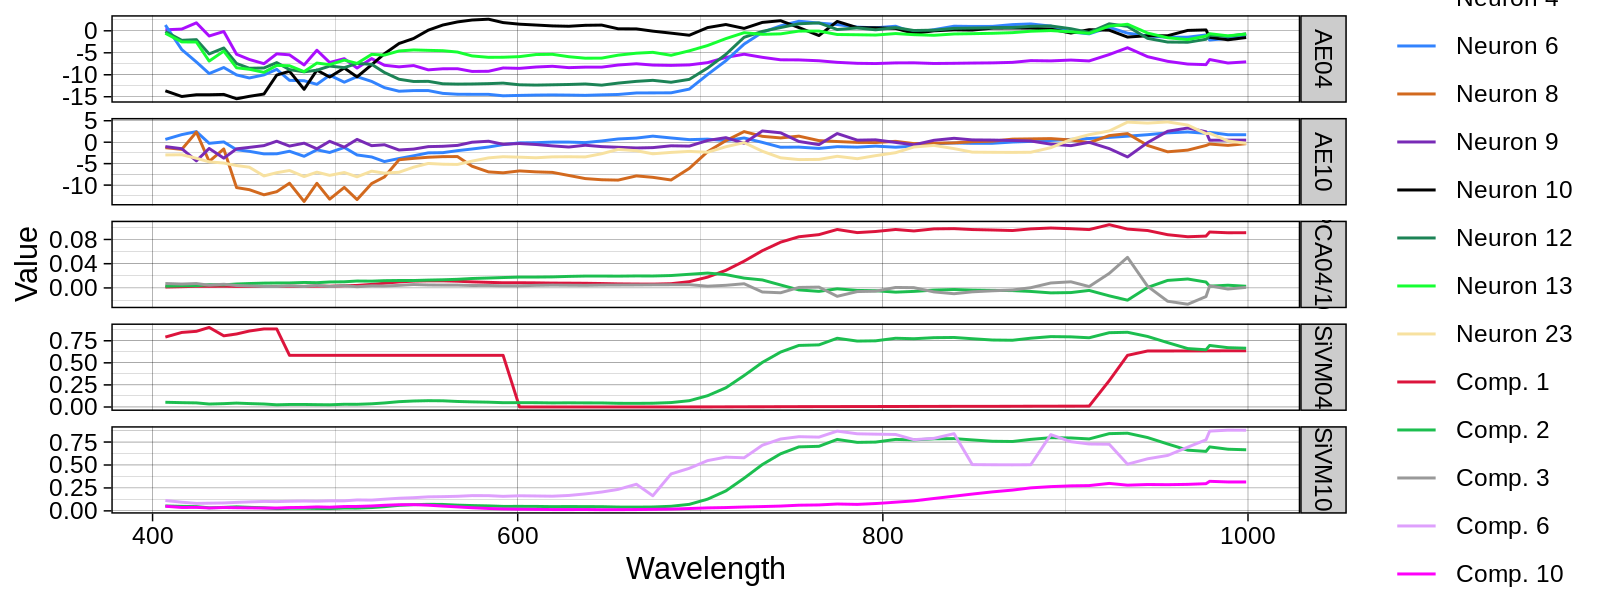

In [126]:
alphcol <- unname(palette.colors(13, palette='Alphabet'))
alphcol[3] <- '#D2691E'
alphcol[5] <- '#000000'
alphcol[9] <- '#DC143C'
alphcol[11] <- '#999999'
alphcol
p_ib <- ggplot(imp_bases, aes(x=as.numeric(levels(wl))[wl], y=value, color=comp)) +
    geom_line() +
    scale_colour_manual(labels=c('Neuron 4', 'Neuron 6', 'Neuron 8', 'Neuron 9', 'Neuron 10', 'Neuron 12',
                                 'Neuron 13', 'Neuron 23', 'Comp. 1', 'Comp. 2', 'Comp. 3', 'Comp. 6', 'Comp. 10'),
                        values=unname(alphcol), name='') +
    xlab('Wavelength') + ylab('Value') +
    theme_linedraw() + theme(plot.title=element_blank(),
                             plot.subtitle=element_blank(),
                             strip.background=element_rect(fill='grey80'),
                             strip.text=element_text(color='black')) +
    facet_grid(drgrp~., scales='free_y', space='fixed')
p_ib
ggsave(file.path(plotdir, 'base_imp_lines_4+10comp.png'),
       p_ib, device='png', width=8, height=7, units='cm', dpi=300, scale=2)